In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession

In [ ]:
#parameter for master can be changed depending on the environment
spark = SparkSession.builder \
    .master("local") \
    .appName("proj") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read using pySpark (seeing 1 record)
df = spark.read.csv("/content/drive/MyDrive/Masters/University of OULU/Y1P4/Big Data Processing and Applications/US_Accidents_March23.csv", header=True, inferSchema=True)
print(f"Number of rows of Total Dataset: {df.count()}")
df.show(1, vertical=True)

Number of rows of Total Dataset: 7728394
-RECORD 0-------------------------------------
 ID                    | A-1                  
 Source                | Source2              
 Severity              | 3                    
 Start_Time            | 2016-02-08 05:46:00  
 End_Time              | 2016-02-08 11:00:00  
 Start_Lat             | 39.865147            
 Start_Lng             | -84.058723           
 End_Lat               | NULL                 
 End_Lng               | NULL                 
 Distance(mi)          | 0.01                 
 Description           | Right lane blocke... 
 Street                | I-70 E               
 City                  | Dayton               
 County                | Montgomery           
 State                 | OH                   
 Zipcode               | 45424                
 Country               | US                   
 Timezone              | US/Eastern           
 Airport_Code          | KFFO                 
 Weather_Timestamp 

In [ ]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [ ]:
from pyspark.sql.functions import col, sum

# Summarize missing values
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twil

In [ ]:
df = df.dropDuplicates()

In [ ]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("Start_Time", to_timestamp("Start_Time"))
df = df.withColumn("End_Time", to_timestamp("End_Time"))
df = df.withColumn("Weather_Timestamp", to_timestamp("Weather_Timestamp"))

In [ ]:
#Handling missing values

#Filling numeric columns with Mean

from pyspark.sql.functions import avg, col

numeric_cols = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]

for col_name in numeric_cols:
    mean_value = df.select(avg(col(col_name))).first()[0]
    if mean_value is not None:
        df = df.fillna({col_name: mean_value})


In [ ]:
# Filling categorical columns with "Unknown"

from pyspark.sql.types import StringType

string_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

fill_unknown = {col_name: "Unknown" for col_name in string_cols}
df = df.fillna(fill_unknown)


In [ ]:
# Dropping rows where Severity is missing
df = df.dropna(subset=["Severity"])


In [ ]:
# Accident duration in minutes
from pyspark.sql.functions import (unix_timestamp, round)

df = df.withColumn("Accident_Duration_Minutes",
                   (unix_timestamp("End_Time") - unix_timestamp("Start_Time")) / 60)


In [ ]:
#Day of the week

from pyspark.sql.functions import date_format

df = df.withColumn("Day_of_Week", date_format("Start_Time", "EEEE"))


In [ ]:
#Hour of the Day

df = df.withColumn("Hour_of_Day", date_format("Start_Time", "H").cast("int"))


In [ ]:
# Rush hour indicator

from pyspark.sql.functions import when

df = df.withColumn("Rush_Hour",
    when((col("Hour_of_Day").between(7,9)) | (col("Hour_of_Day").between(16,18)), 1).otherwise(0)
)


In [ ]:
# Converting Distance from Miles to Kilometers
df = df.withColumn("Distance_km", (col("Distance(mi)") * 1.60934))


In [ ]:
df.coalesce(1).write.csv("Final_Dataset.csv", header=True, mode="overwrite")


In [ ]:
# Summarize missing values after feature engineering
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-------------------------+-----------+-----------+---------+-----------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming

In [ ]:
print(df.count())

7728394


# EDA

In [ ]:
# read using pySpark (seeing 1 record)
df = spark.read.csv("/content/drive/MyDrive/Masters/University of OULU/Y1P4/Big Data Processing and Applications/Final_Dataset.csv", header=True, inferSchema=True)
print(f"Number of rows of Total Dataset: {df.count()}")
df.show(1, vertical=True)

Number of rows of Total Dataset: 7728394
-RECORD 0-----------------------------------------
 ID                        | A-3426647            
 Source                    | Source1              
 Severity                  | 2                    
 Start_Time                | 2016-12-16 16:09:33  
 End_Time                  | 2016-12-16 22:09:33  
 Start_Lat                 | 44.83152000000001    
 Start_Lng                 | -91.45307            
 End_Lat                   | 44.83802             
 End_Lng                   | -91.4432             
 Distance(mi)              | 0.66                 
 Description               | At WI-312/North X... 
 Street                    | US-53 N              
 City                      | Eau Claire           
 County                    | Eau Claire           
 State                     | WI                   
 Zipcode                   | 54703                
 Country                   | US                   
 Timezone                  | US/Central  

In [ ]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("Start_Time", to_timestamp("Start_Time")) # Converting time columns to datetime

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Accidents per Day')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of Accidents')

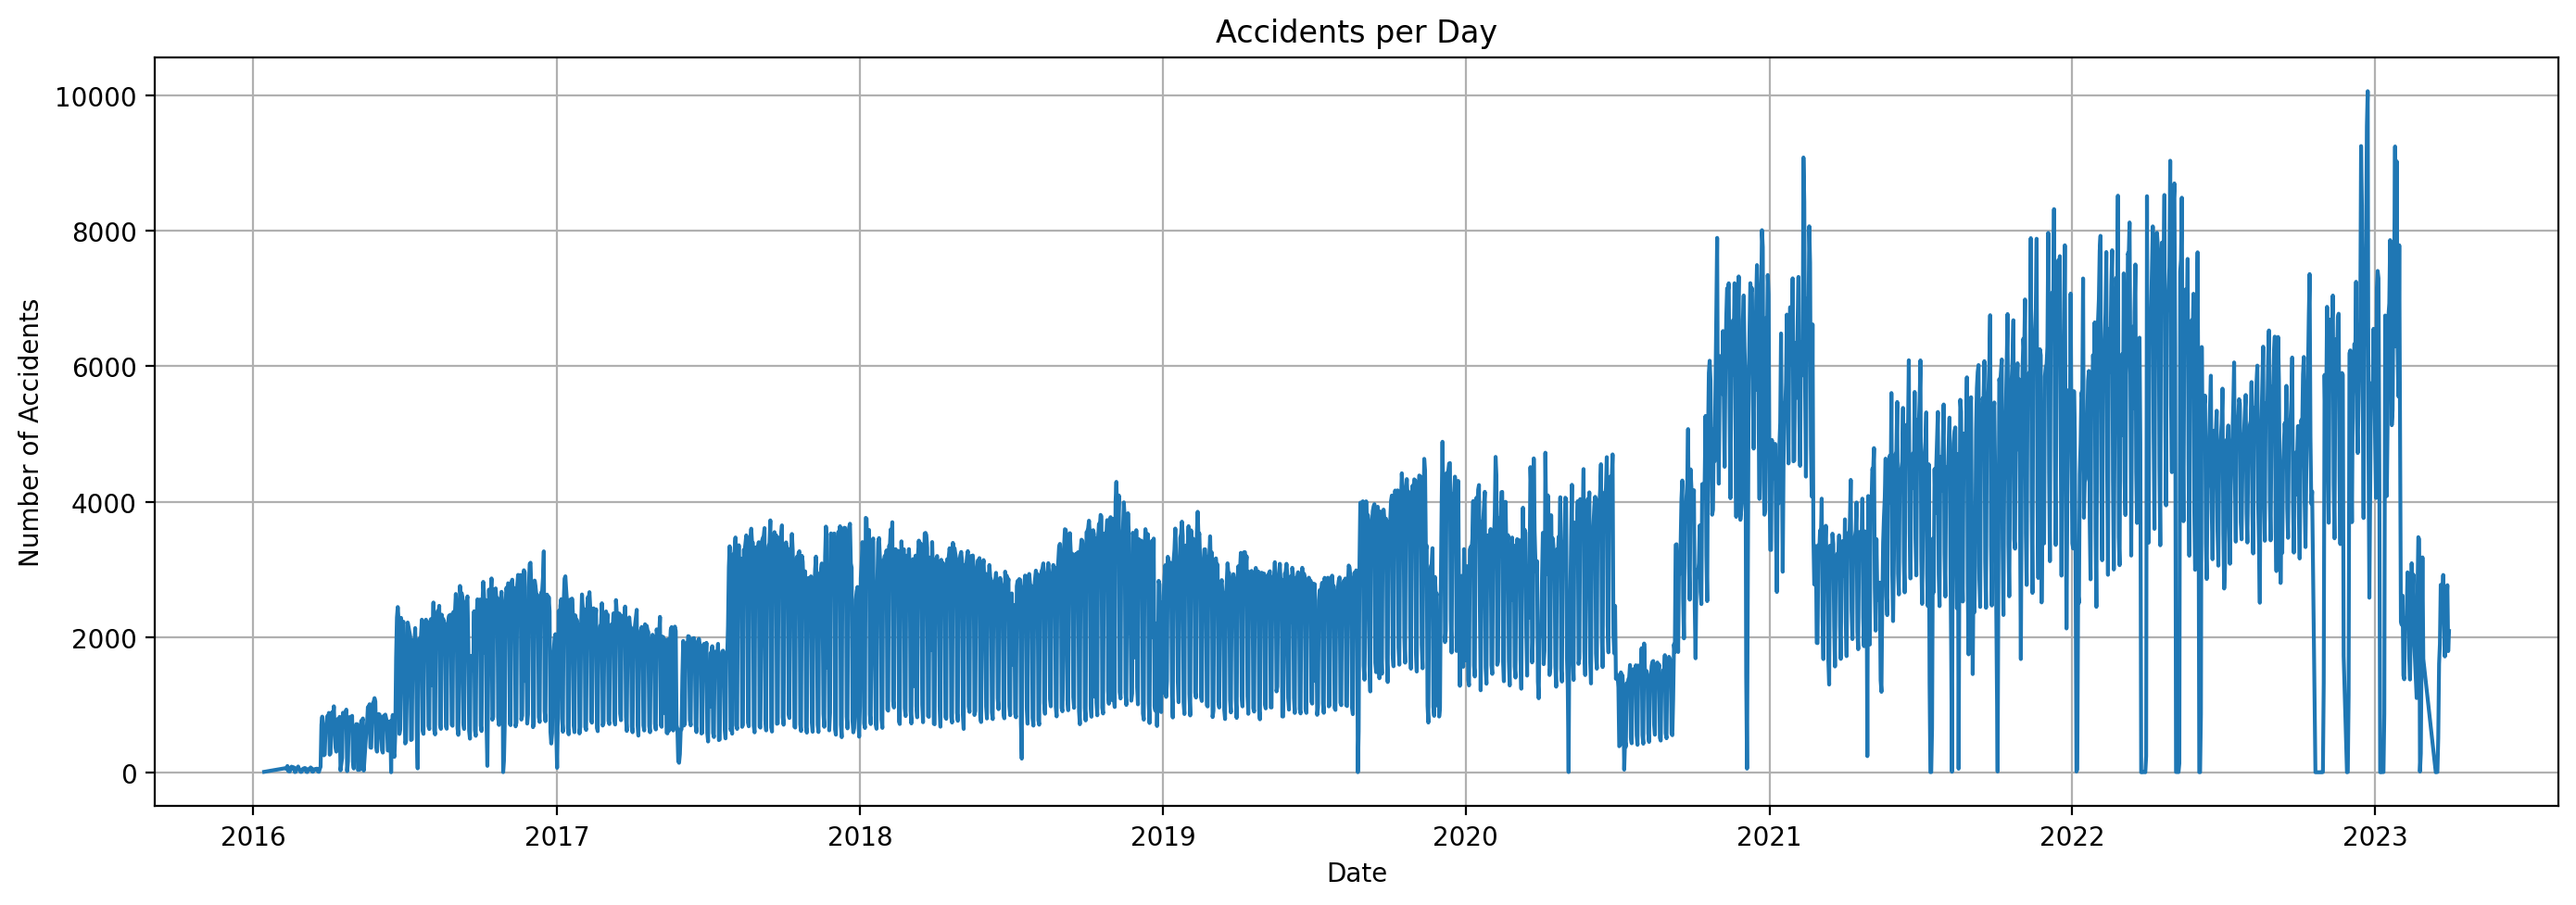

In [ ]:
# Number of accident per day

from pyspark.sql.functions import to_date, count

accidents_per_day = df.withColumn("Date", to_date("Start_Time")) \
                      .groupBy("Date") \
                      .agg(count("*").alias("Accident_Count")) \
                      .orderBy("Date")

# Converting to Pandas for visualization
accidents_pd = accidents_per_day.toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(accidents_pd["Date"], accidents_pd["Accident_Count"])
plt.title("Accidents per Day")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

<ipython-input-7-298296240444>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accidents_by_hour_pd, x="Hour", y="Accident_Count", palette="Blues_d")


<Axes: xlabel='Hour', ylabel='Accident_Count'>

Text(0.5, 1.0, 'Accidents by Hour of Day')

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Count')

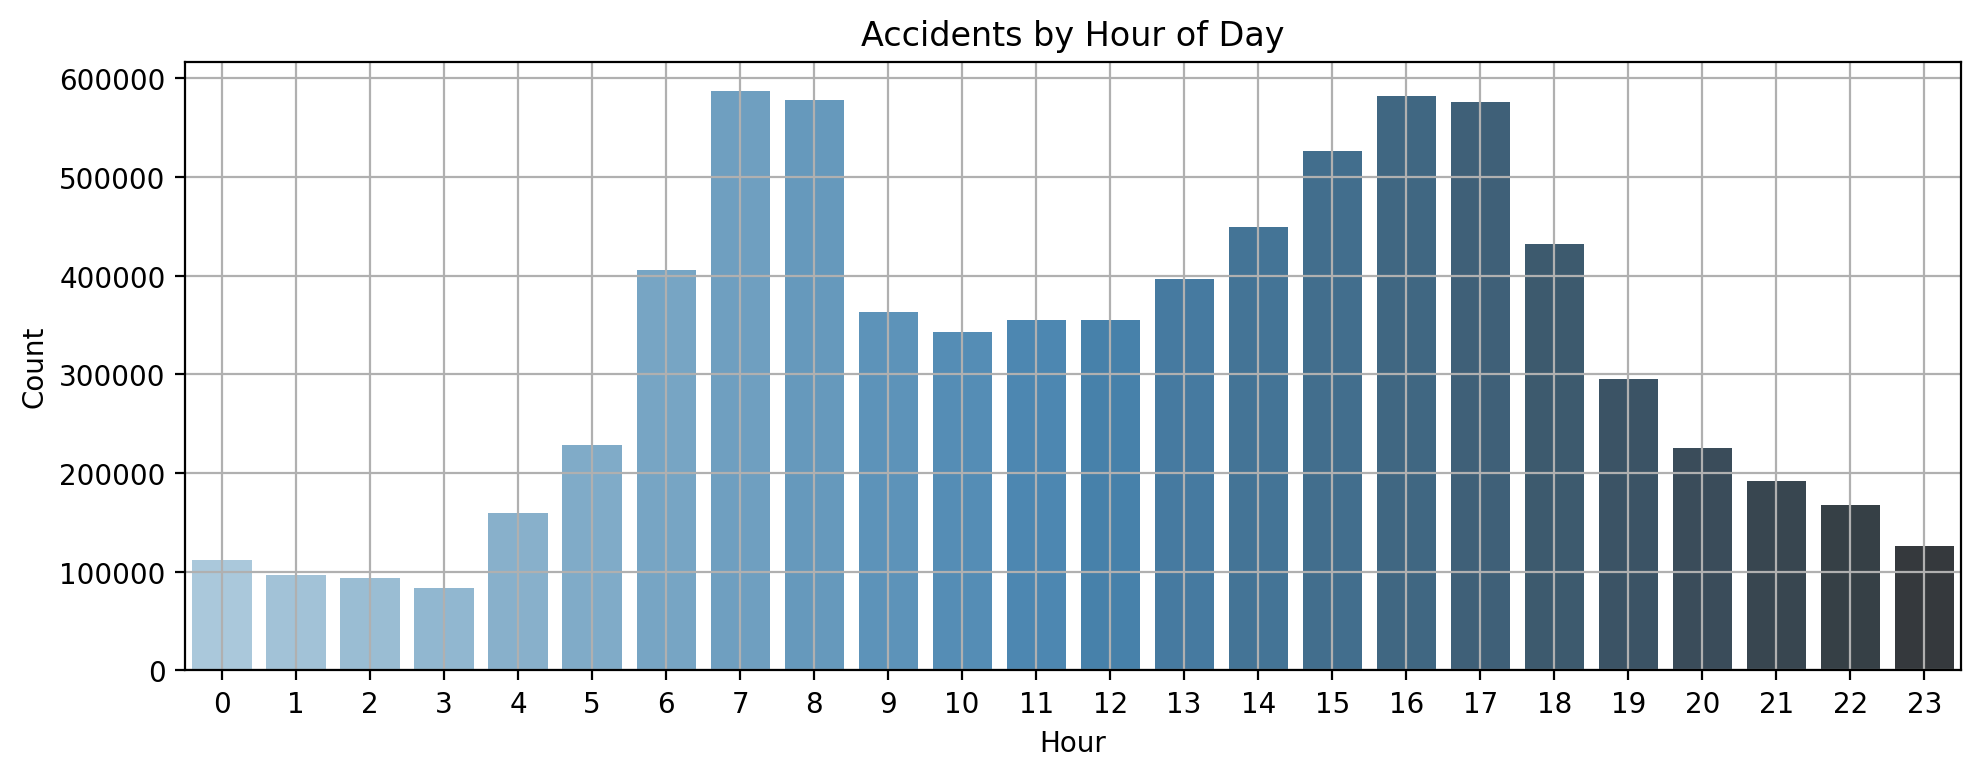

In [ ]:
# Accident by hour of day

from pyspark.sql.functions import hour

accidents_by_hour = df.withColumn("Hour", hour("Start_Time")) \
                      .groupBy("Hour") \
                      .agg(count("*").alias("Accident_Count")) \
                      .orderBy("Hour")

accidents_by_hour_pd = accidents_by_hour.toPandas()

import seaborn as sns
plt.figure(figsize=(10, 4))
sns.barplot(data=accidents_by_hour_pd, x="Hour", y="Accident_Count", palette="Blues_d")
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Hour', ylabel='DayOfWeek'>

Text(0.5, 1.0, 'Heatmap of Accidents: Day of Week vs Hour')

Text(0.5, 36.72222222222221, 'Hour of Day')

Text(120.72222222222221, 0.5, 'Day of Week')

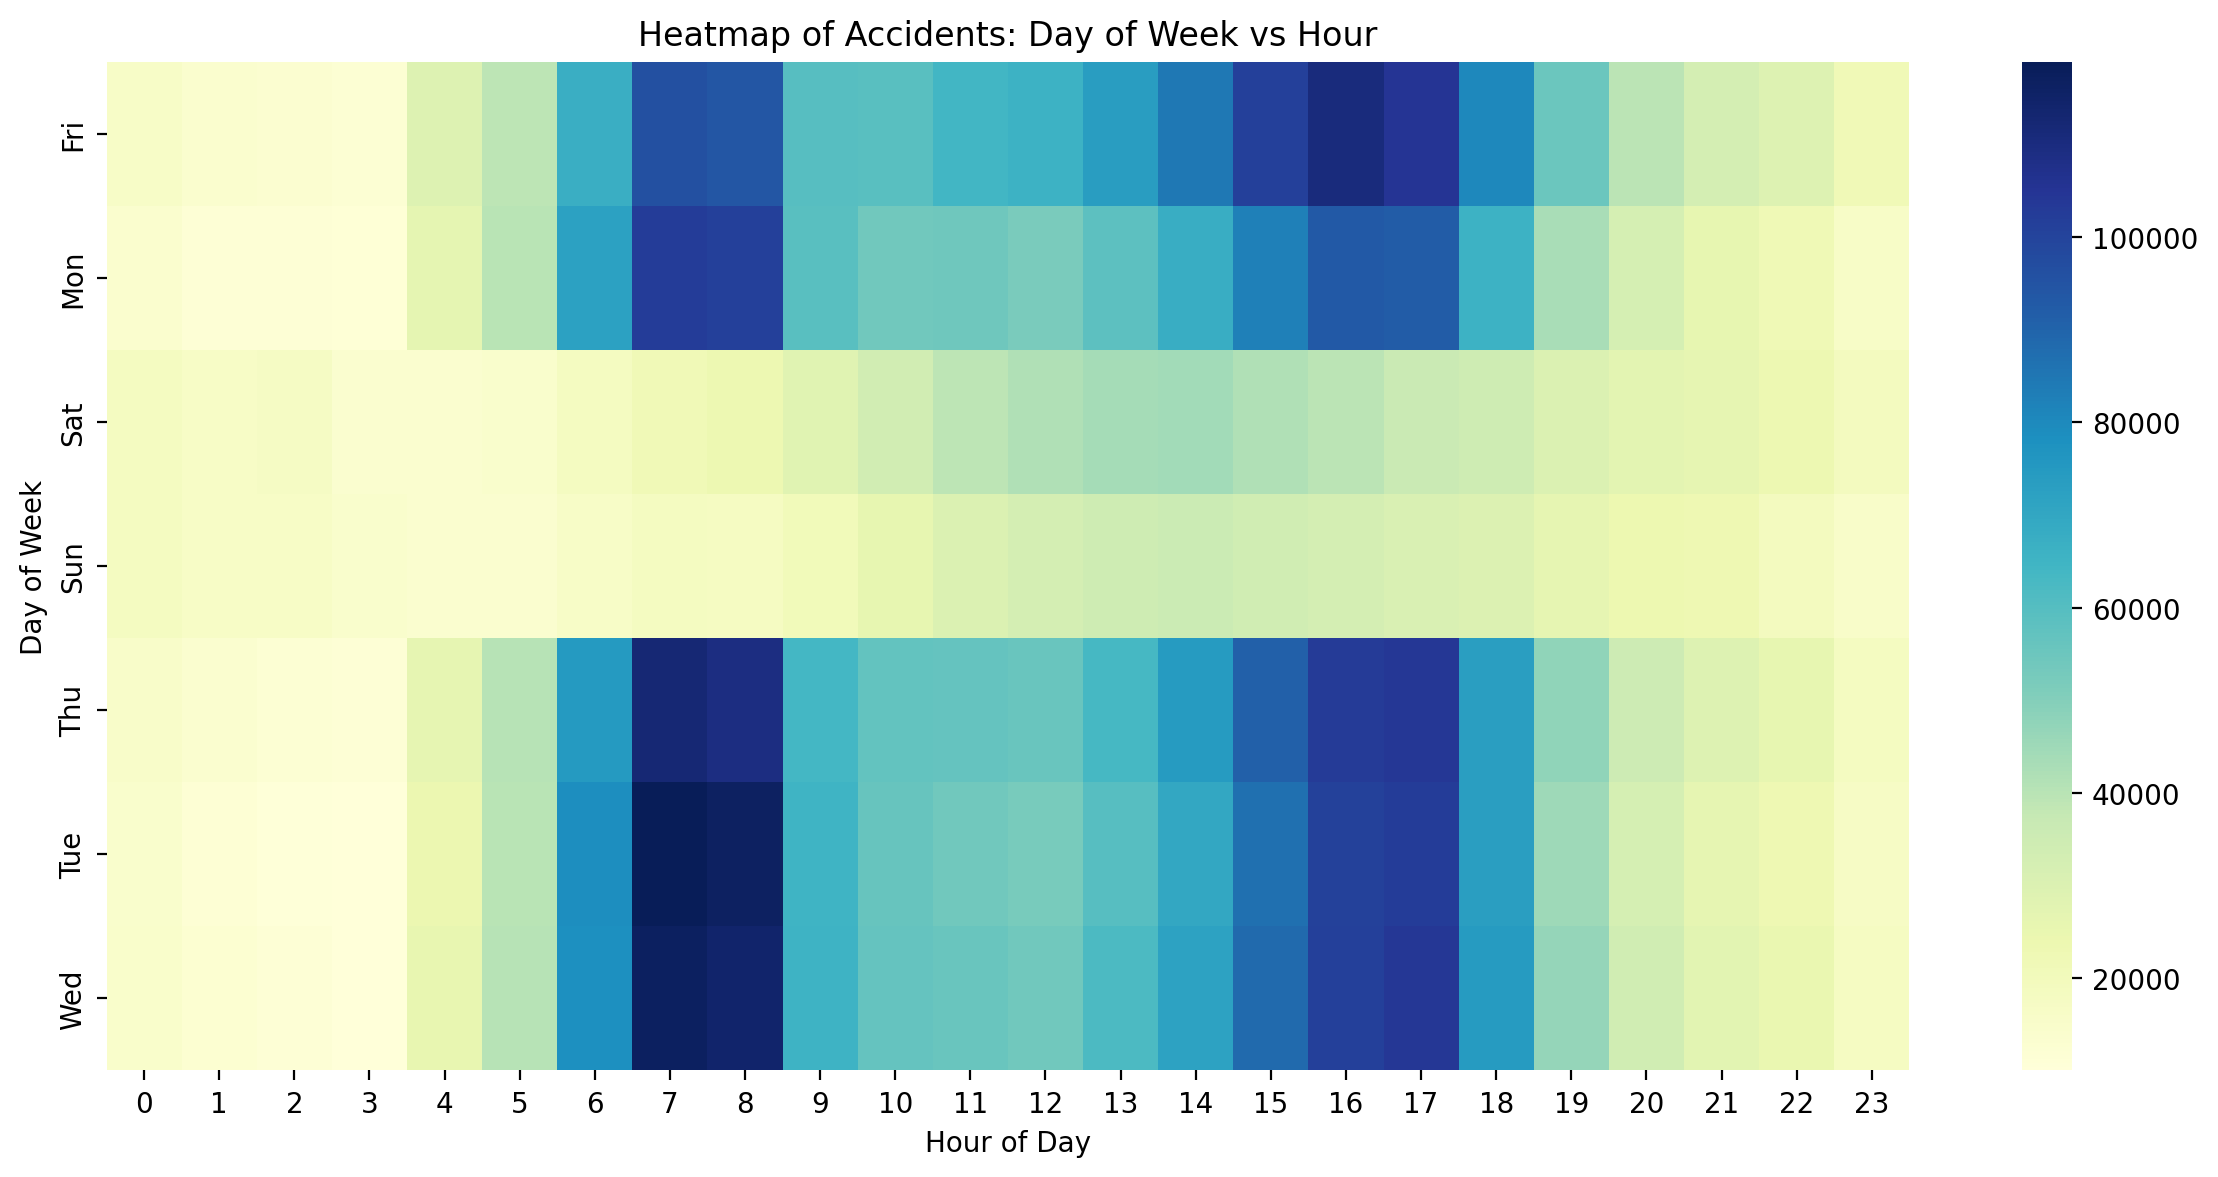

In [ ]:
# HeatMap between Day vs Hour

from pyspark.sql.functions import date_format

df_temp = df.withColumn("DayOfWeek", date_format("Start_Time", "E")) \
            .withColumn("Hour", hour("Start_Time"))

heat_df = df_temp.groupBy("DayOfWeek", "Hour") \
                 .agg(count("*").alias("Accidents")) \
                 .toPandas()

# Pivot for heatmap
heatmap_data = heat_df.pivot(index="DayOfWeek", columns="Hour", values="Accidents").fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title("Heatmap of Accidents: Day of Week vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


Categorical Analysis

<ipython-input-11-40baa27f4375>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=severity_pd, x="Severity", y="Count", palette="viridis")


<Axes: xlabel='Severity', ylabel='Count'>

Text(0.5, 1.0, 'Accidents by Severity')

Text(0.5, 0, 'Severity Level')

Text(0, 0.5, 'Number of Accidents')

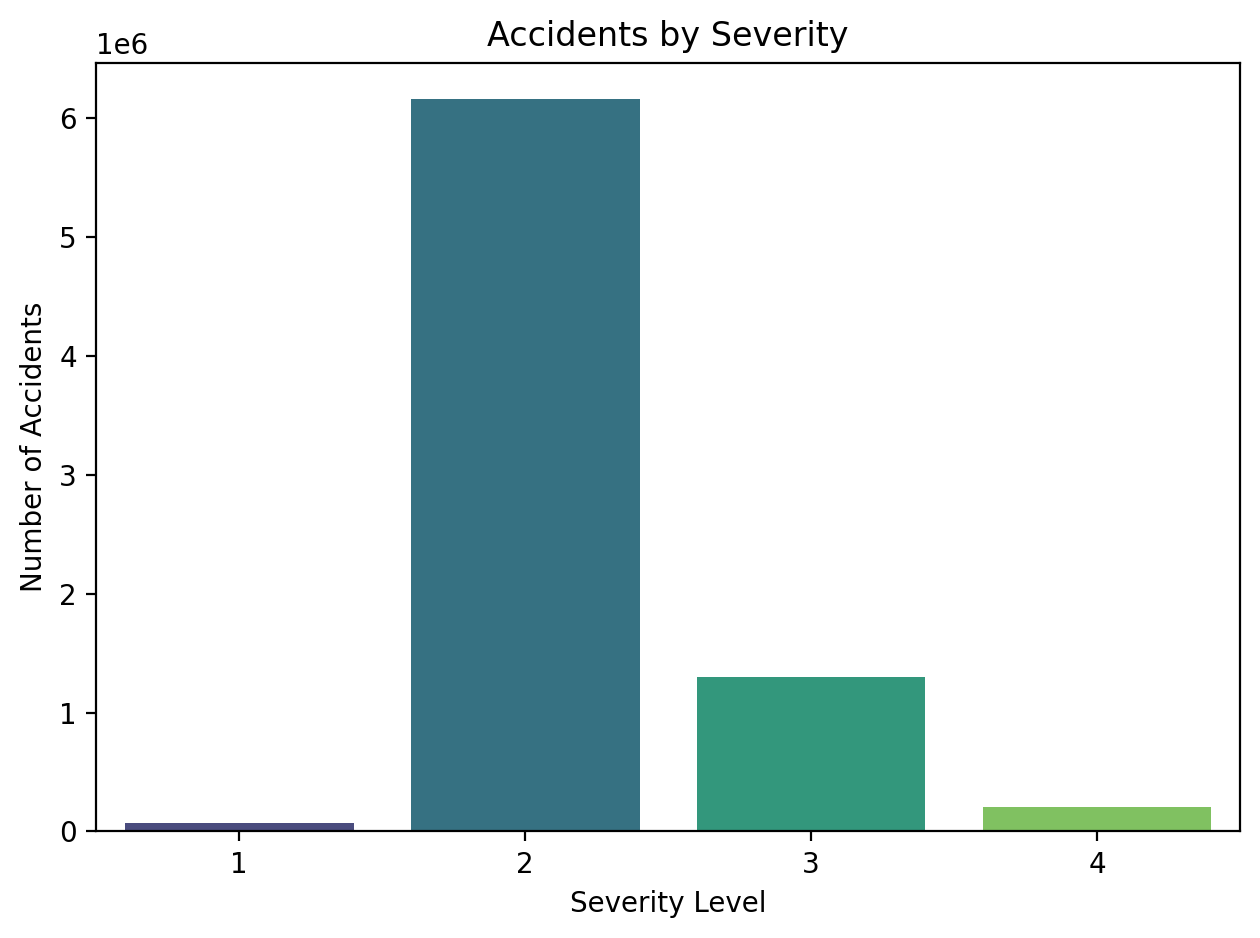

In [ ]:
# Bar Chart (Accidents per Severity)

severity_count = df.groupBy("Severity").agg(count("*").alias("Count")).orderBy("Severity")
severity_pd = severity_count.toPandas()

sns.barplot(data=severity_pd, x="Severity", y="Count", palette="viridis")
plt.title("Accidents by Severity")
plt.xlabel("Severity Level")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x79511c40f590>,
 [Text(-0.8699733196770424, 0.6731615133458737, 'Source3'),
  Text(-0.8235825468004867, -0.7291857024144291, 'Source2'),
  Text(0.8517974830106375, 0.6960179939748274, 'Source1')],
 [Text(-0.47453090164202305, 0.3671790072795675, '1.3%'),
  Text(-0.44922684370935634, -0.39773765586241583, '42.8%'),
  Text(0.46461680891489315, 0.379646178531724, '56.0%')])

Text(0.5, 1.0, 'Accident Reports by Source')

(np.float64(-1.0999996900111753),
 np.float64(1.0999991069567447),
 np.float64(-1.0999946218853294),
 np.float64(1.0999997250287699))

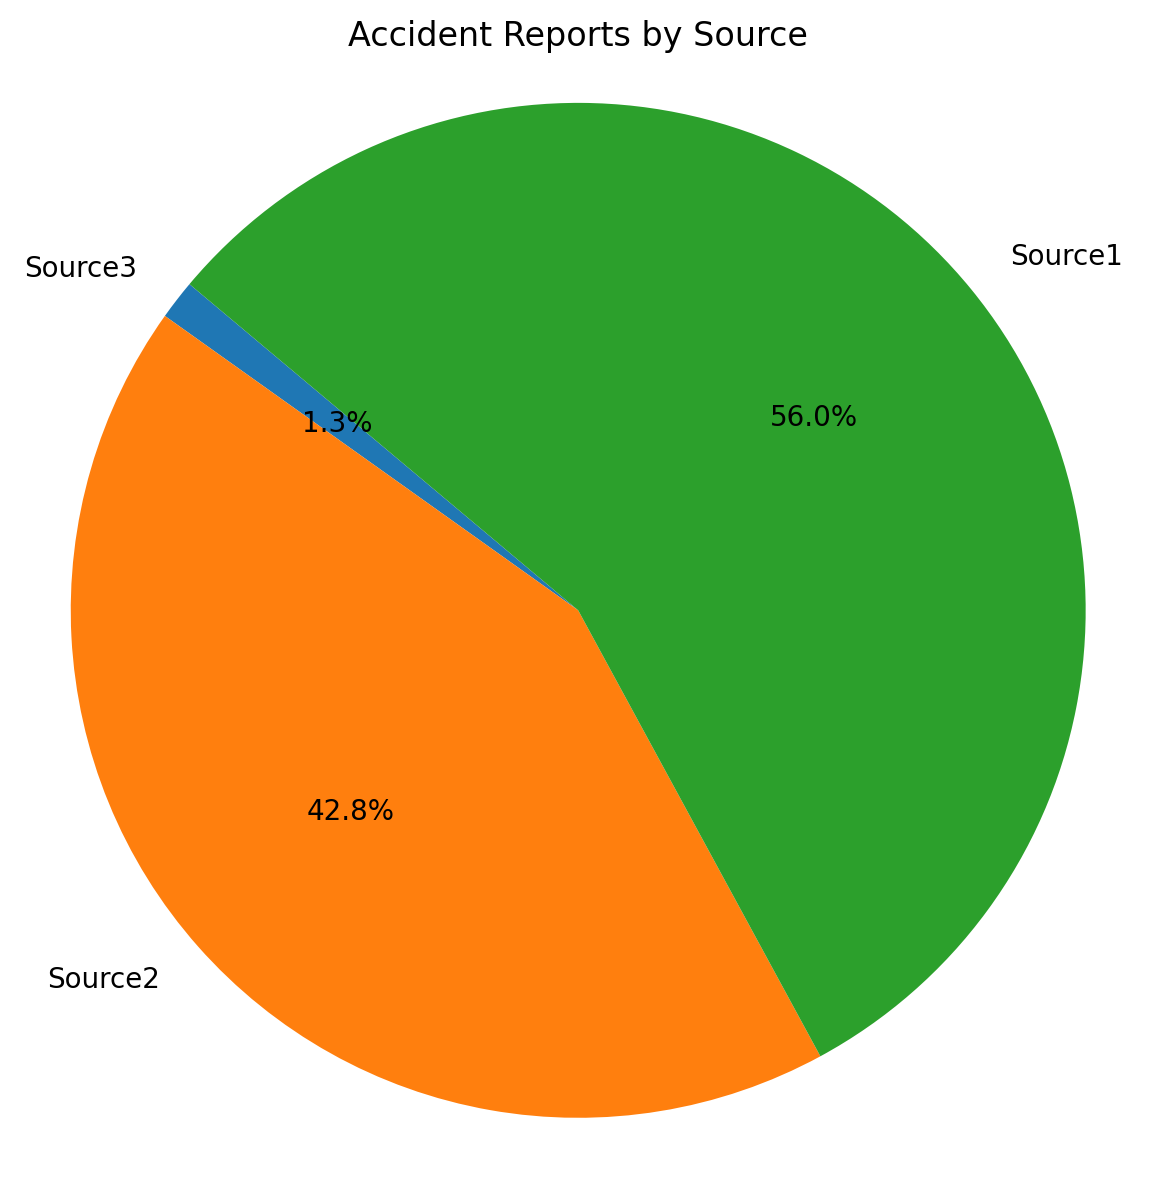

In [ ]:
# Pie Chart (Accidents by Source)

source_count = df.groupBy("Source").agg(count("*").alias("Count"))
source_pd = source_count.toPandas()

plt.figure(figsize=(6,6))
plt.pie(source_pd["Count"], labels=source_pd["Source"], autopct='%1.1f%%', startangle=140)
plt.title("Accident Reports by Source")
plt.axis("equal")
plt.tight_layout()
plt.show()


<ipython-input-13-9ce6be6a9092>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box_pd, x="Severity", y="Distance(mi)", palette="Set3")


<Axes: xlabel='Severity', ylabel='Distance(mi)'>

Text(0.5, 1.0, 'Severity vs Affected Distance')

Text(0.5, 0, 'Severity')

Text(0, 0.5, 'Distance (miles)')

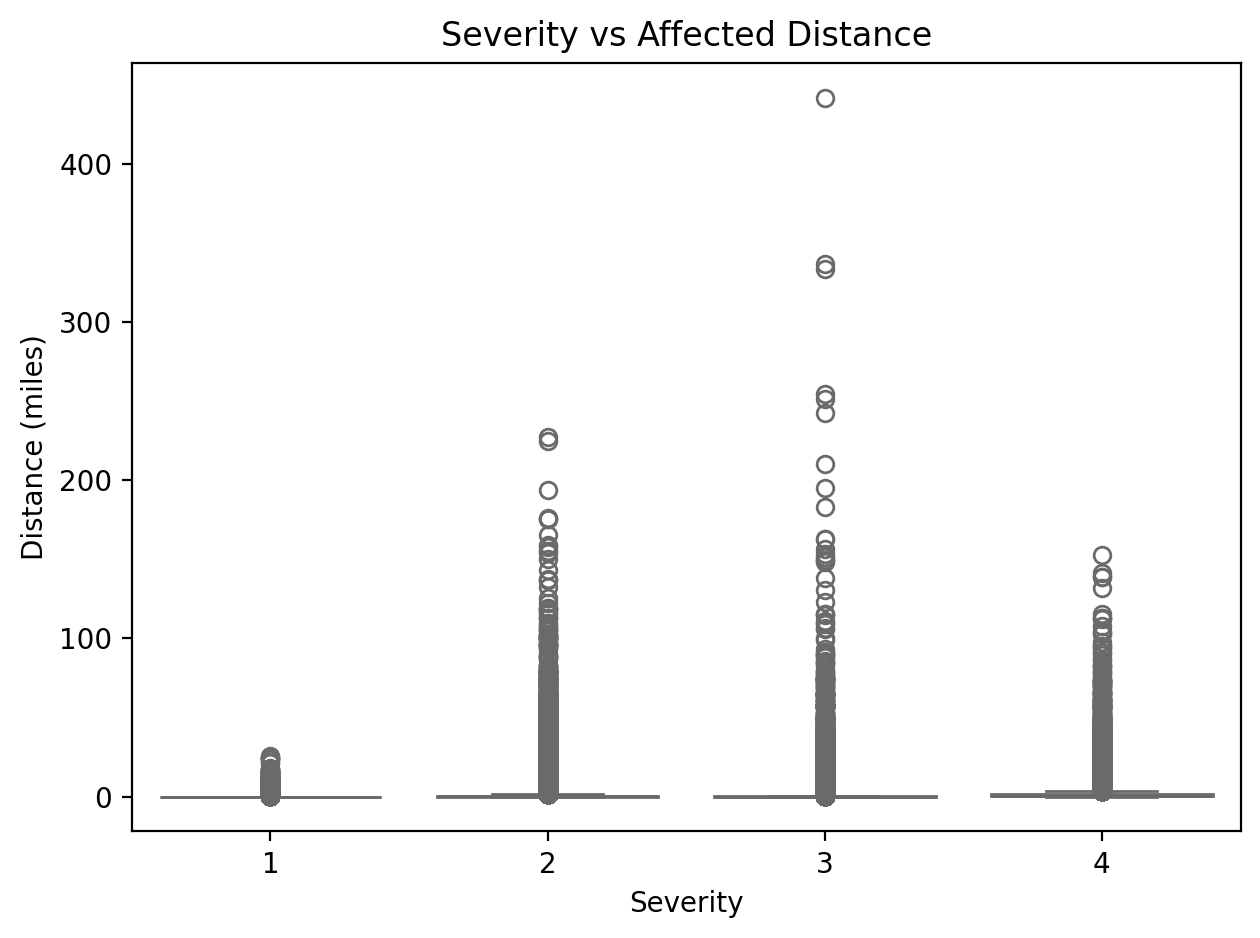

In [ ]:
# Box Plot (Severity vs Distance)

df_box = df.select("Severity", "Distance(mi)").dropna()
df_box_pd = df_box.toPandas()

sns.boxplot(data=df_box_pd, x="Severity", y="Distance(mi)", palette="Set3")
plt.title("Severity vs Affected Distance")
plt.xlabel("Severity")
plt.ylabel("Distance (miles)")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Year', ylabel='Count'>

Text(0.5, 1.0, 'Trend of Accident Severity Over the Years')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Accident Count')

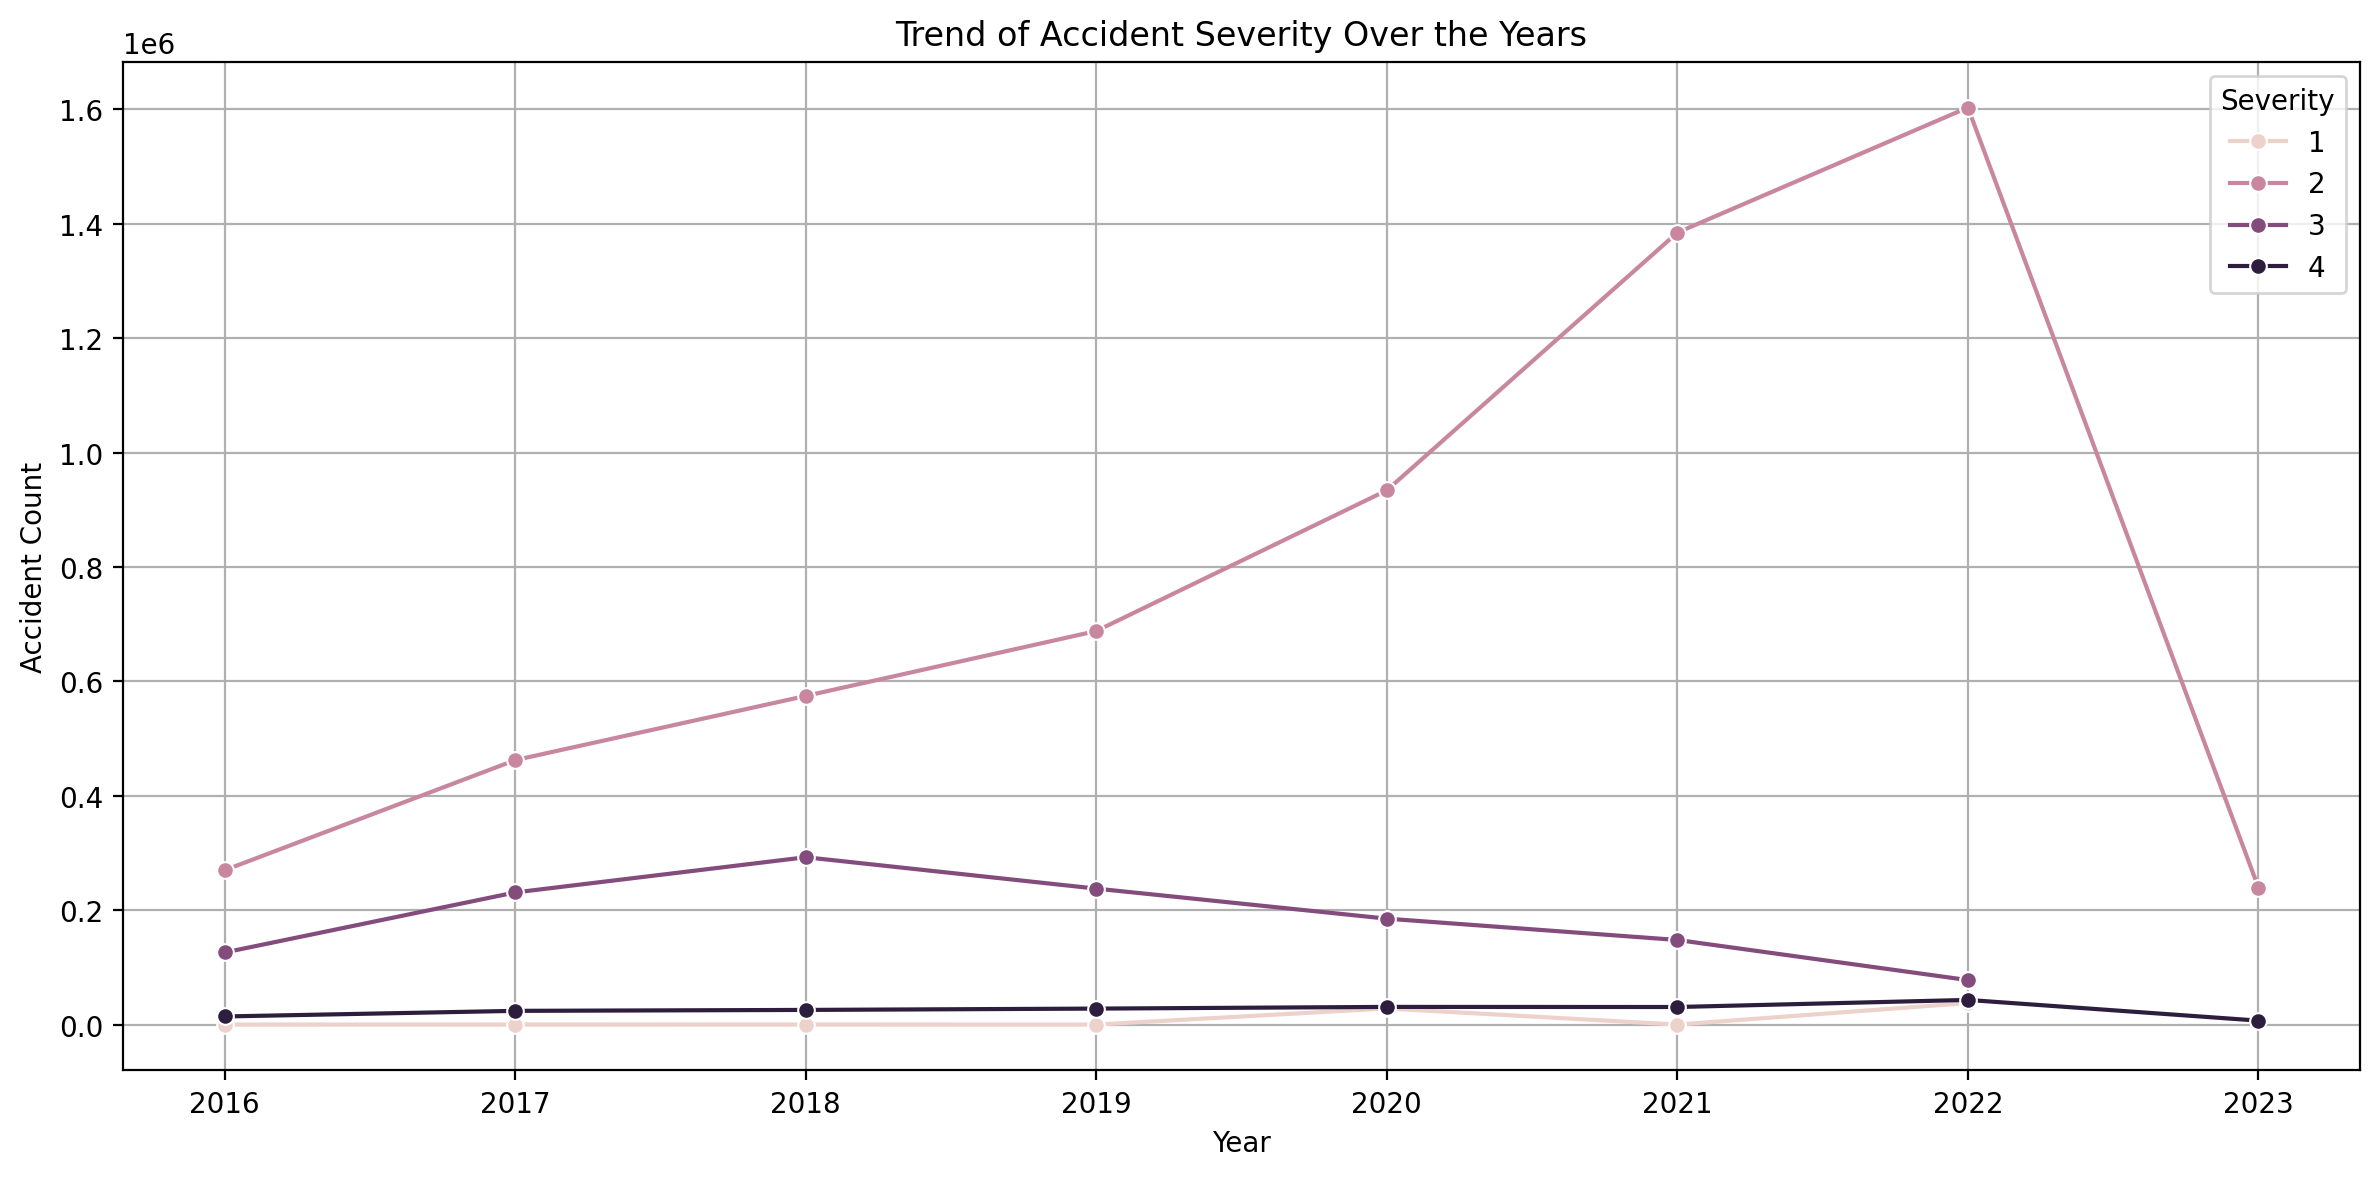

In [ ]:
# Trend of Severity Over Time

from pyspark.sql.functions import year, count
import seaborn as sns
import matplotlib.pyplot as plt

# Extract year from Start_Time
df_yearly = df.withColumn("Year", year("Start_Time"))

# Group by Year and Severity, then count
severity_trend = df_yearly.groupBy("Year", "Severity").agg(count("*").alias("Count")).orderBy("Year").toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=severity_trend, x="Year", y="Count", hue="Severity", marker="o")
plt.title("Trend of Accident Severity Over the Years")
plt.xlabel("Year")
plt.ylabel("Accident Count")
plt.tight_layout()
plt.grid(True)
plt.show()

Spark session stopped so reinitializing

In [ ]:
# Restarting SparkSession safely if stopped
from pyspark.sql import SparkSession

# Stopping Spark if it's already running (optional but safe)
try:
    spark.stop()
except:
    pass

# Re-initializing Spark
spark = SparkSession.builder \
    .appName("proj") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [ ]:
df = spark.read.csv("/content/drive/MyDrive/Masters/University of OULU/Y1P4/Big Data Processing and Applications/Final_Dataset.csv", header=True, inferSchema=True)


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features (Sampled)')

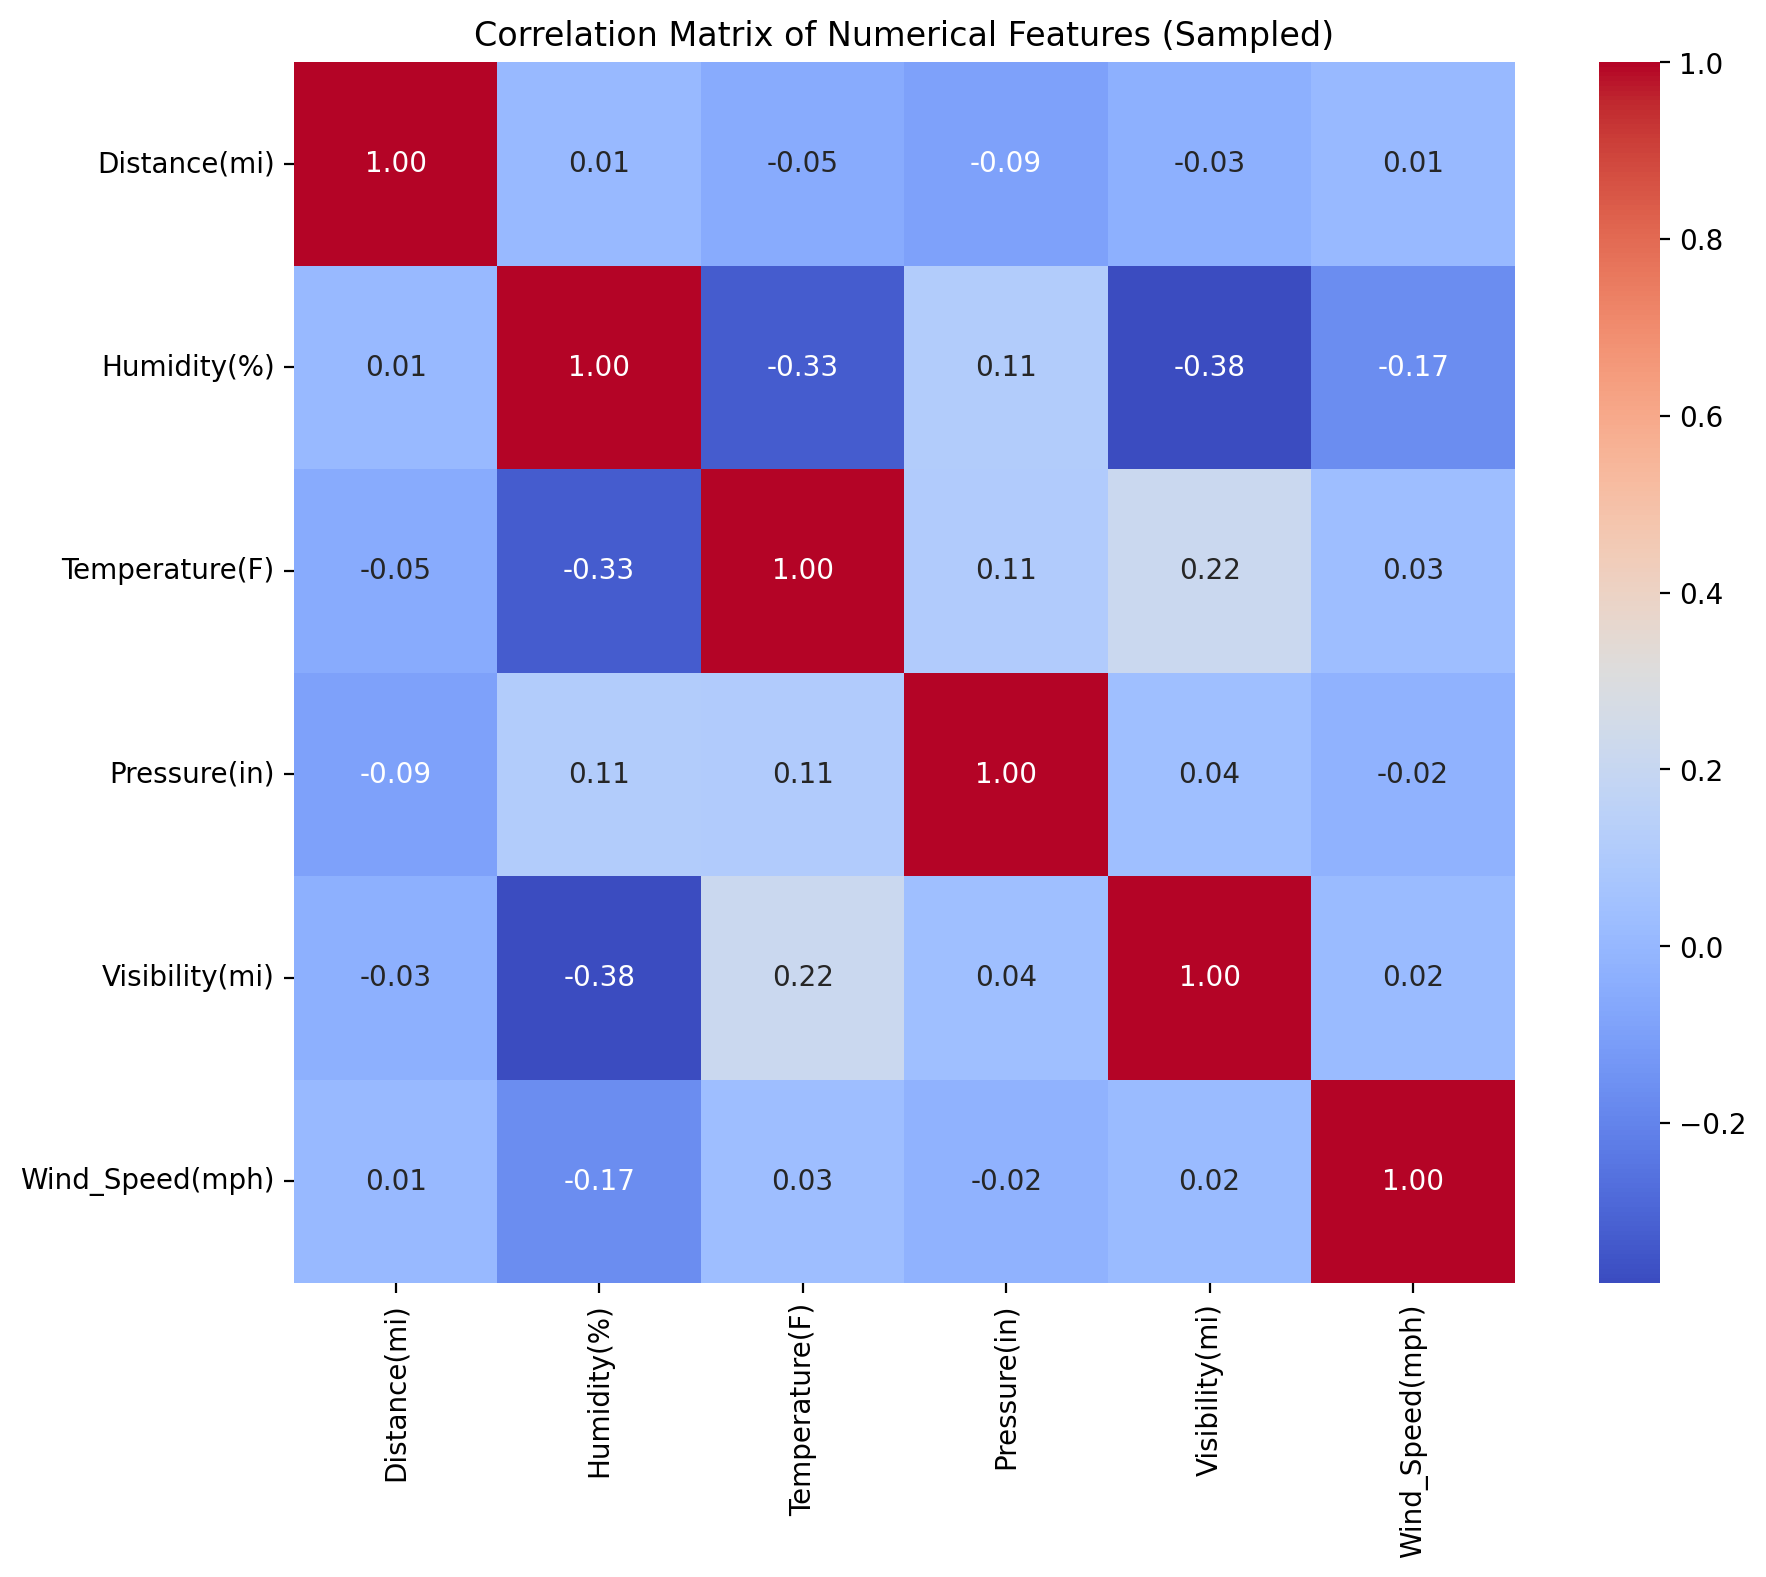

In [ ]:
# Correlation Matrix of Numerical Features (with Sampling)

# Selecting numerical columns
numerical_columns = [
    "Distance(mi)", "Humidity(%)", "Temperature(F)",
    "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)"
]

# Sample around 20% of data or limit rows
sampled_df = df.select(numerical_columns).dropna().sample(fraction=0.2, seed=42)

# OR: Use a specific row limit (e.g., 10,000 rows)
# sampled_df = df.select(numerical_columns).dropna().limit(10000)

# Converting to Pandas
num_df = sampled_df.toPandas()

# Plotting correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Numerical Features (Sampled)")
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='Distance(mi)'>

Text(0.5, 1.0, 'Box Plot of Distance(mi)')

<Axes: >

<Axes: xlabel='Humidity(%)'>

Text(0.5, 1.0, 'Box Plot of Humidity(%)')

<Axes: >

<Axes: xlabel='Temperature(F)'>

Text(0.5, 1.0, 'Box Plot of Temperature(F)')

<Axes: >

<Axes: xlabel='Pressure(in)'>

Text(0.5, 1.0, 'Box Plot of Pressure(in)')

<Axes: >

<Axes: xlabel='Visibility(mi)'>

Text(0.5, 1.0, 'Box Plot of Visibility(mi)')

<Axes: >

<Axes: xlabel='Wind_Speed(mph)'>

Text(0.5, 1.0, 'Box Plot of Wind_Speed(mph)')

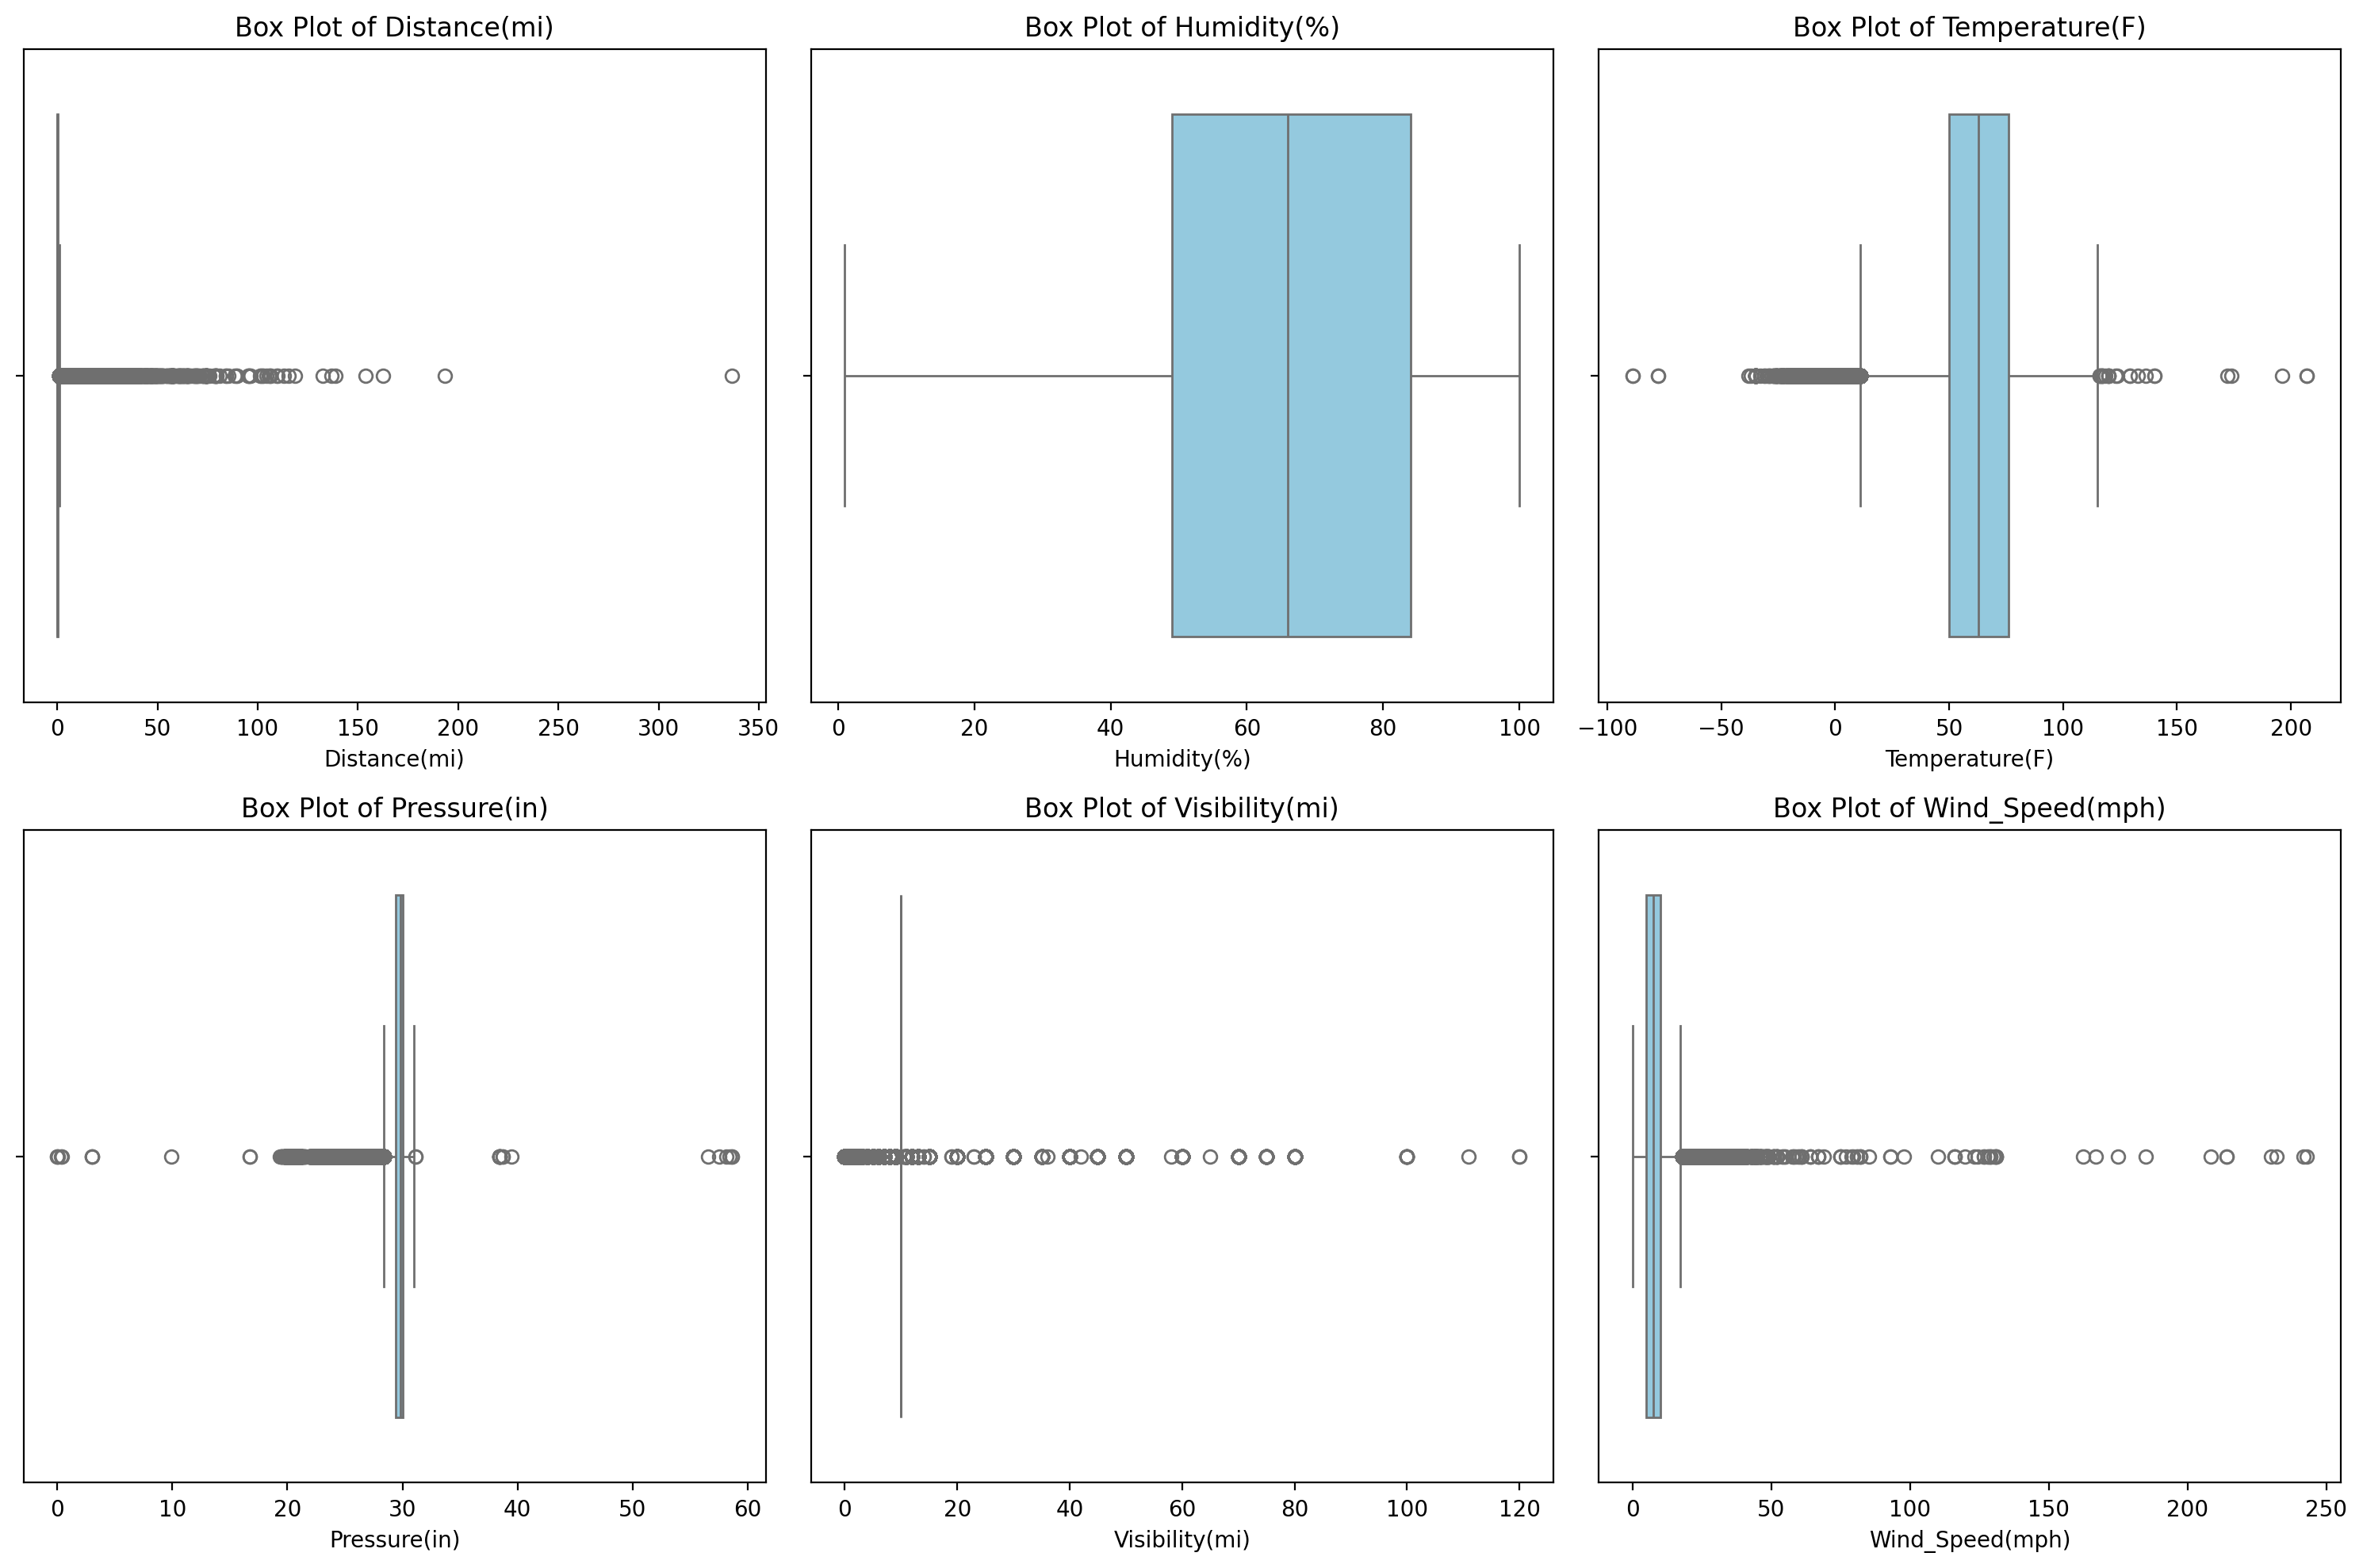

In [ ]:
# Outlier Detection Using Box Plots

# Using the same numerical features
plt.figure(figsize=(15, 10))
for i, col_name in enumerate(numerical_columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=num_df[col_name], color="skyblue")
    plt.title(f"Box Plot of {col_name}")
    plt.tight_layout()
plt.show()

# Spatial Analysis

In [ ]:
# read using pySpark (seeing 1 record)
df = spark.read.csv("/content/drive/MyDrive/Final_Dataset.csv", header=True, inferSchema=True)
print(f"Number of rows of Total Dataset: {df.count()}")
df.show(1, vertical=True)

Number of rows of Total Dataset: 7728394
-RECORD 0-----------------------------------------
 ID                        | A-3426647            
 Source                    | Source1              
 Severity                  | 2                    
 Start_Time                | 2016-12-16 16:09:33  
 End_Time                  | 2016-12-16 22:09:33  
 Start_Lat                 | 44.83152000000001    
 Start_Lng                 | -91.45307            
 End_Lat                   | 44.83802             
 End_Lng                   | -91.4432             
 Distance(mi)              | 0.66                 
 Description               | At WI-312/North X... 
 Street                    | US-53 N              
 City                      | Eau Claire           
 County                    | Eau Claire           
 State                     | WI                   
 Zipcode                   | 54703                
 Country                   | US                   
 Timezone                  | US/Central  

In [ ]:
# ---------------------------------------------
# 5. Spatial Analysis (Hotspot Detection)
# Convert lat/lng to grid ➔ Apply KMeans ➔ Detect accident-prone areas
# ---------------------------------------------

# Step 1: Select Latitude and Longitude columns
df_small = df.select("Start_Lat", "Start_Lng").dropna()

# Step 2: Rename for easier handling
df_small = df_small.withColumnRenamed("Start_Lat", "Latitude").withColumnRenamed("Start_Lng", "Longitude")

# Step 3: Convert to Pandas (if your memory allows)
pdf = df_small.toPandas()

# Randomly sample 500,000 rows for faster analysis
pdf_sampled = pdf.sample(n=500000, random_state=42)



KMeans(n_clusters=20, random_state=42)

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Detected Accident Hotspots')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

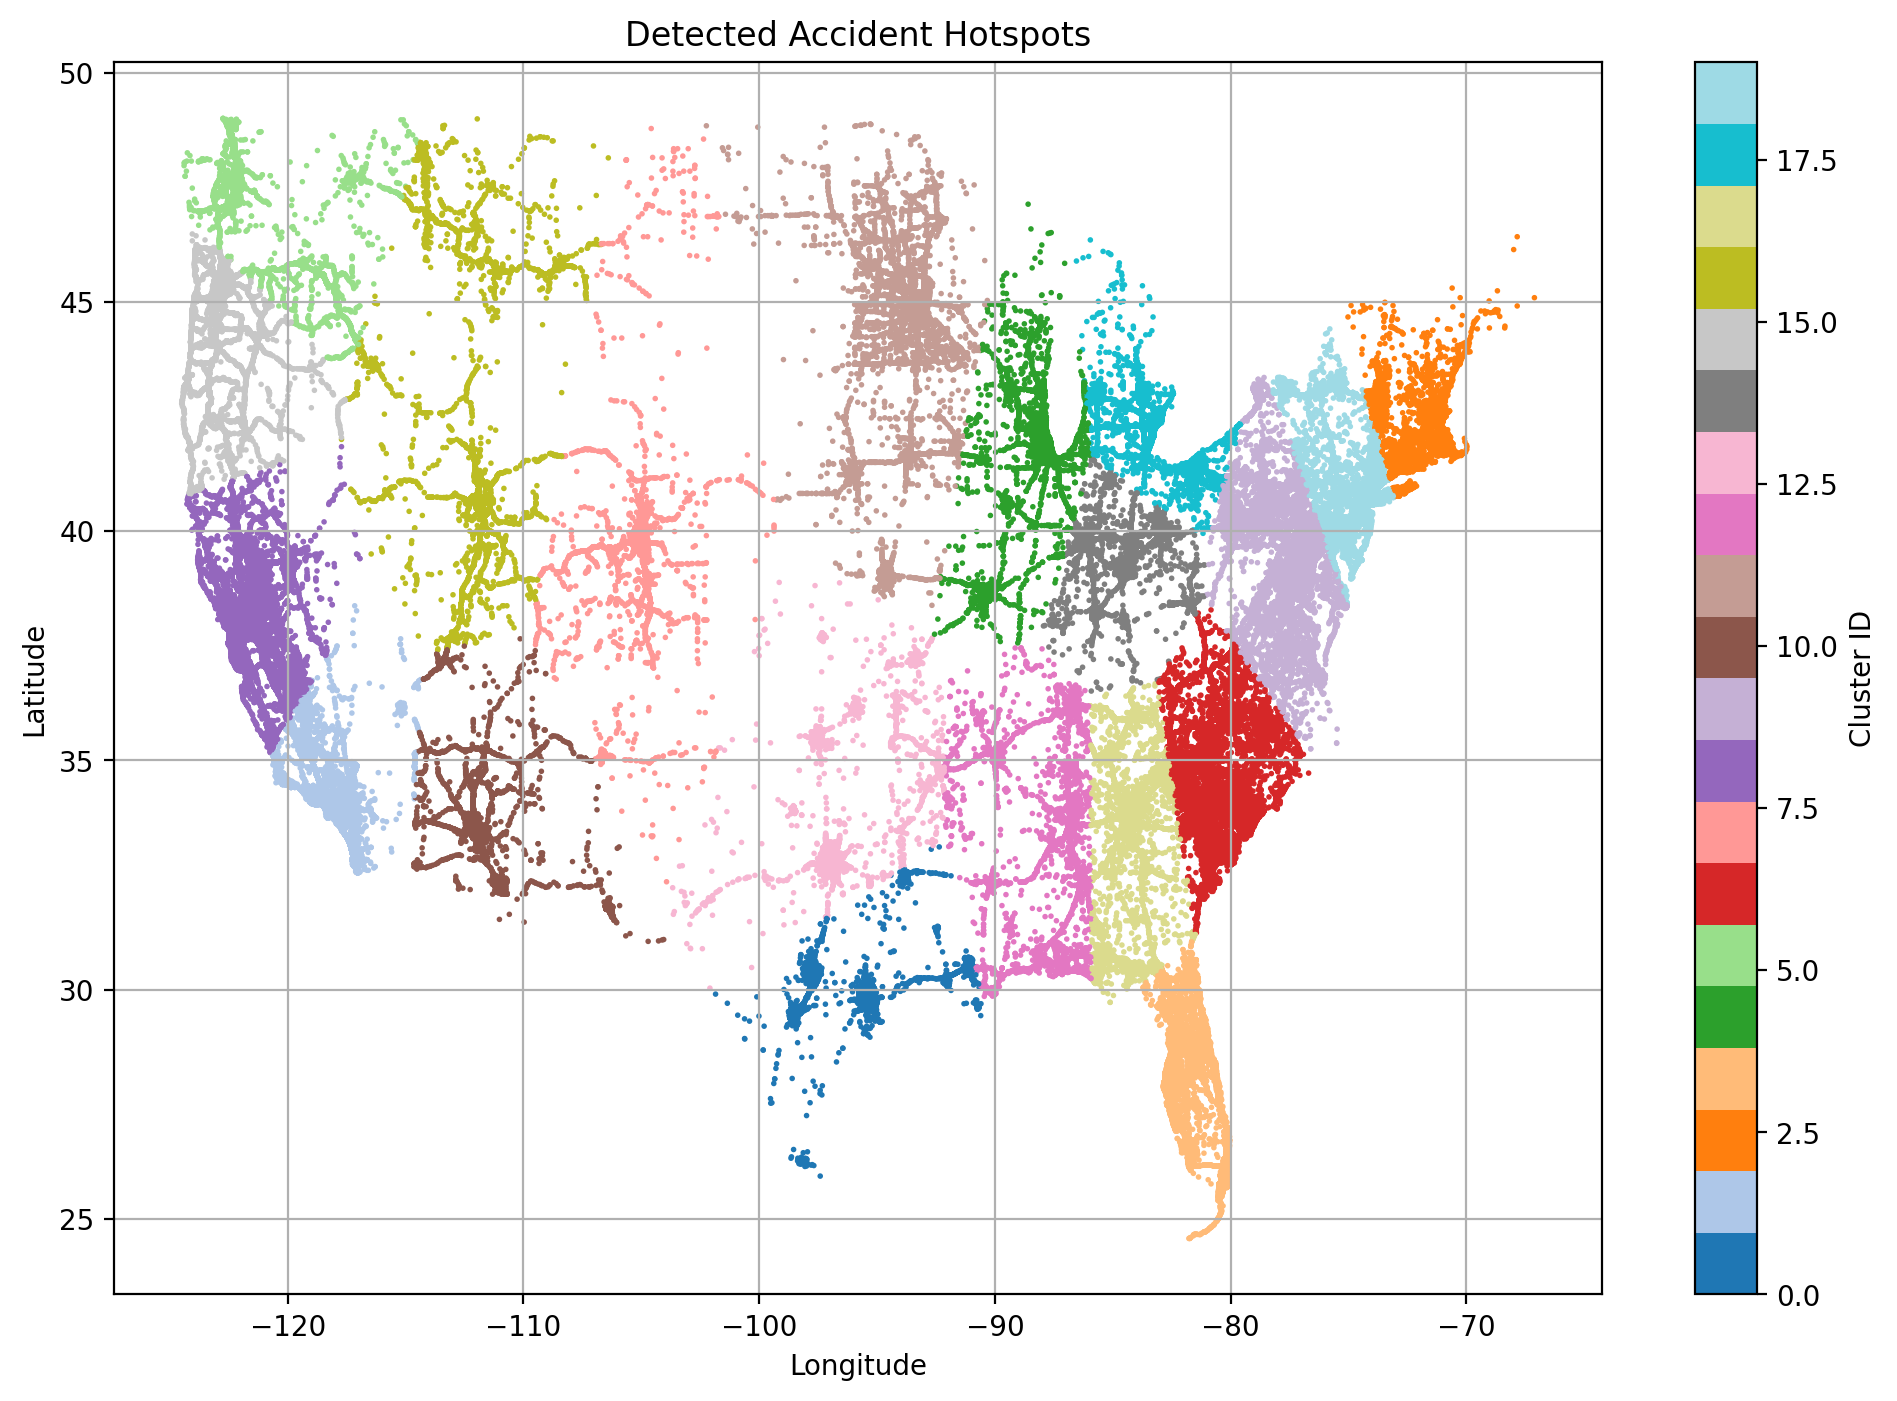

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Use the sampled or full dataset
X = pdf_sampled[['Latitude', 'Longitude']].values

# Step 1: Round coordinates to form grids (optional)
X_rounded = np.round(X, decimals=2)  # ~1 km grid

# Step 2: Cluster using KMeans
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(X_rounded)

# Step 3: Plot clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_rounded[:, 1], X_rounded[:, 0], c=kmeans.labels_, cmap='tab20', s=1)
plt.colorbar(label="Cluster ID")
plt.title("Detected Accident Hotspots")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

<ipython-input-7-3f046b1cc8c5>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette='tab20')


<Axes: >

Text(0.5, 0, 'Cluster ID')

Text(0, 0.5, 'Number of Accidents')

Text(0.5, 1.0, 'Number of Accidents per Cluster')

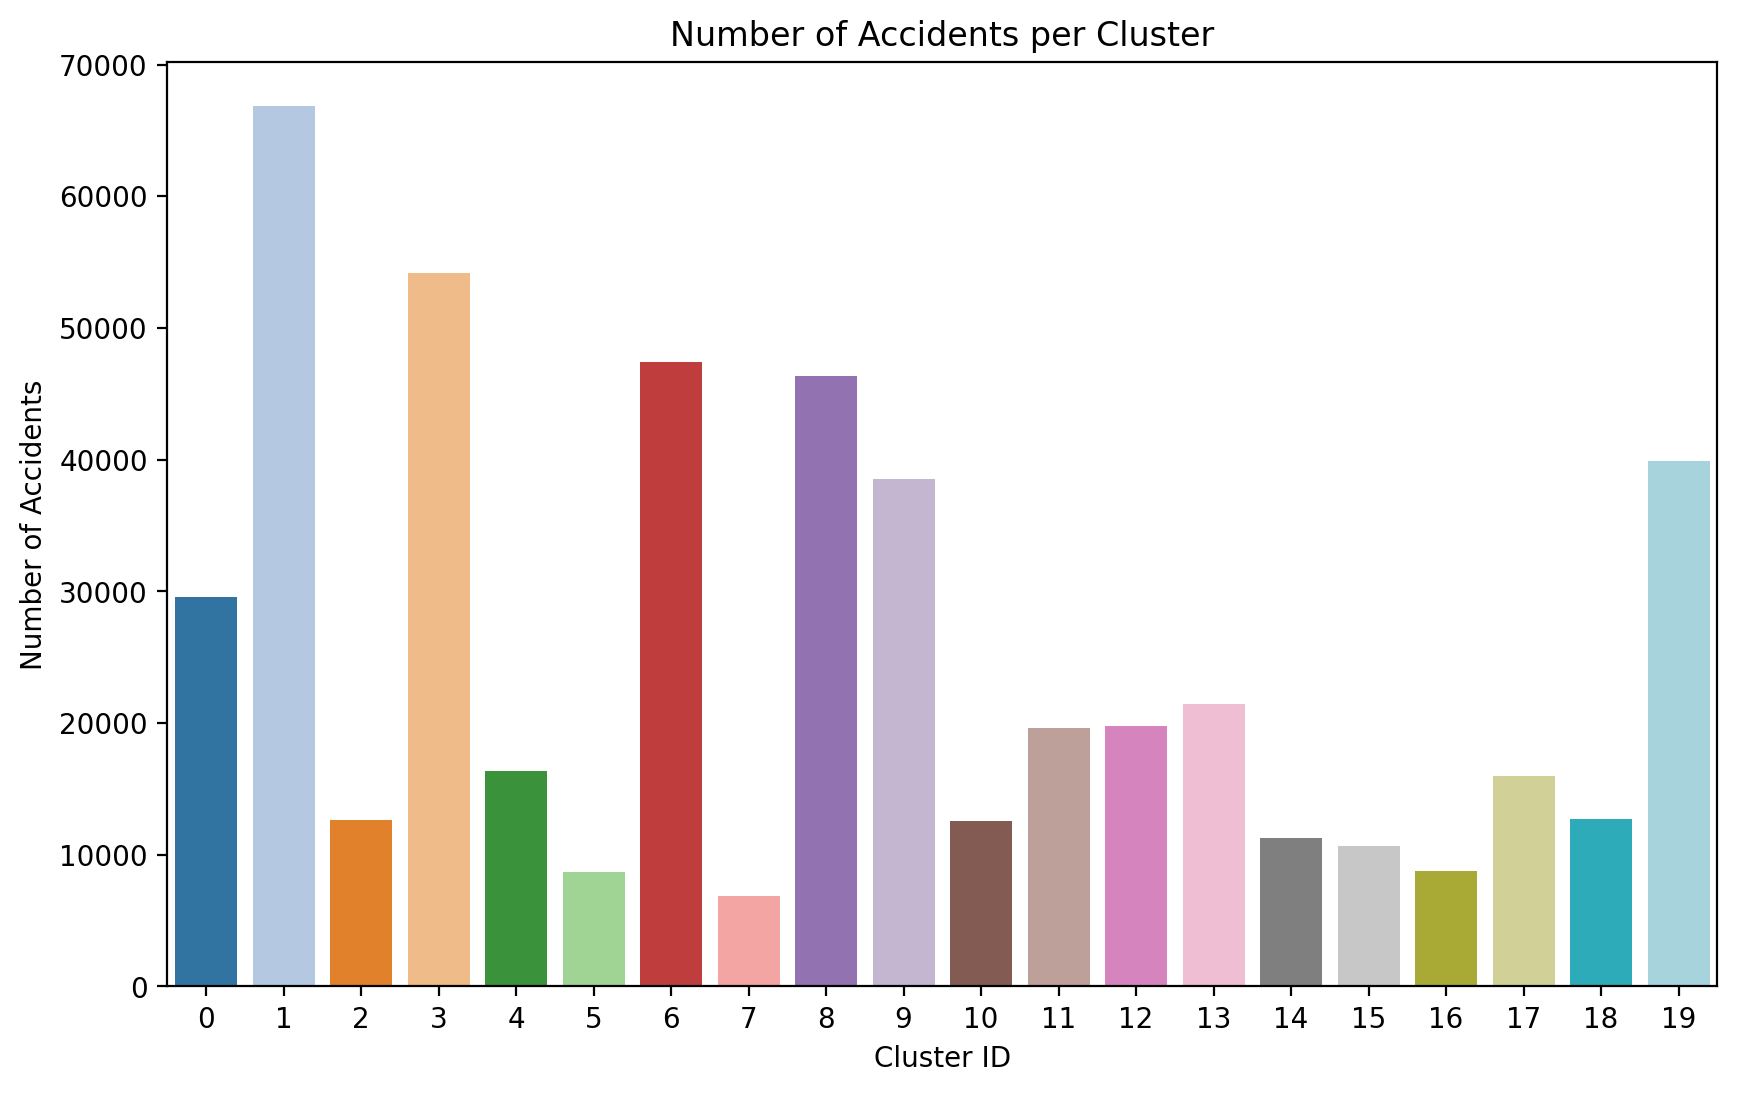

In [ ]:
import seaborn as sns

# Count how many points are in each cluster
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=unique, y=counts, palette='tab20')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents per Cluster')
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Zoomed View of Hotspot Cluster 6')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

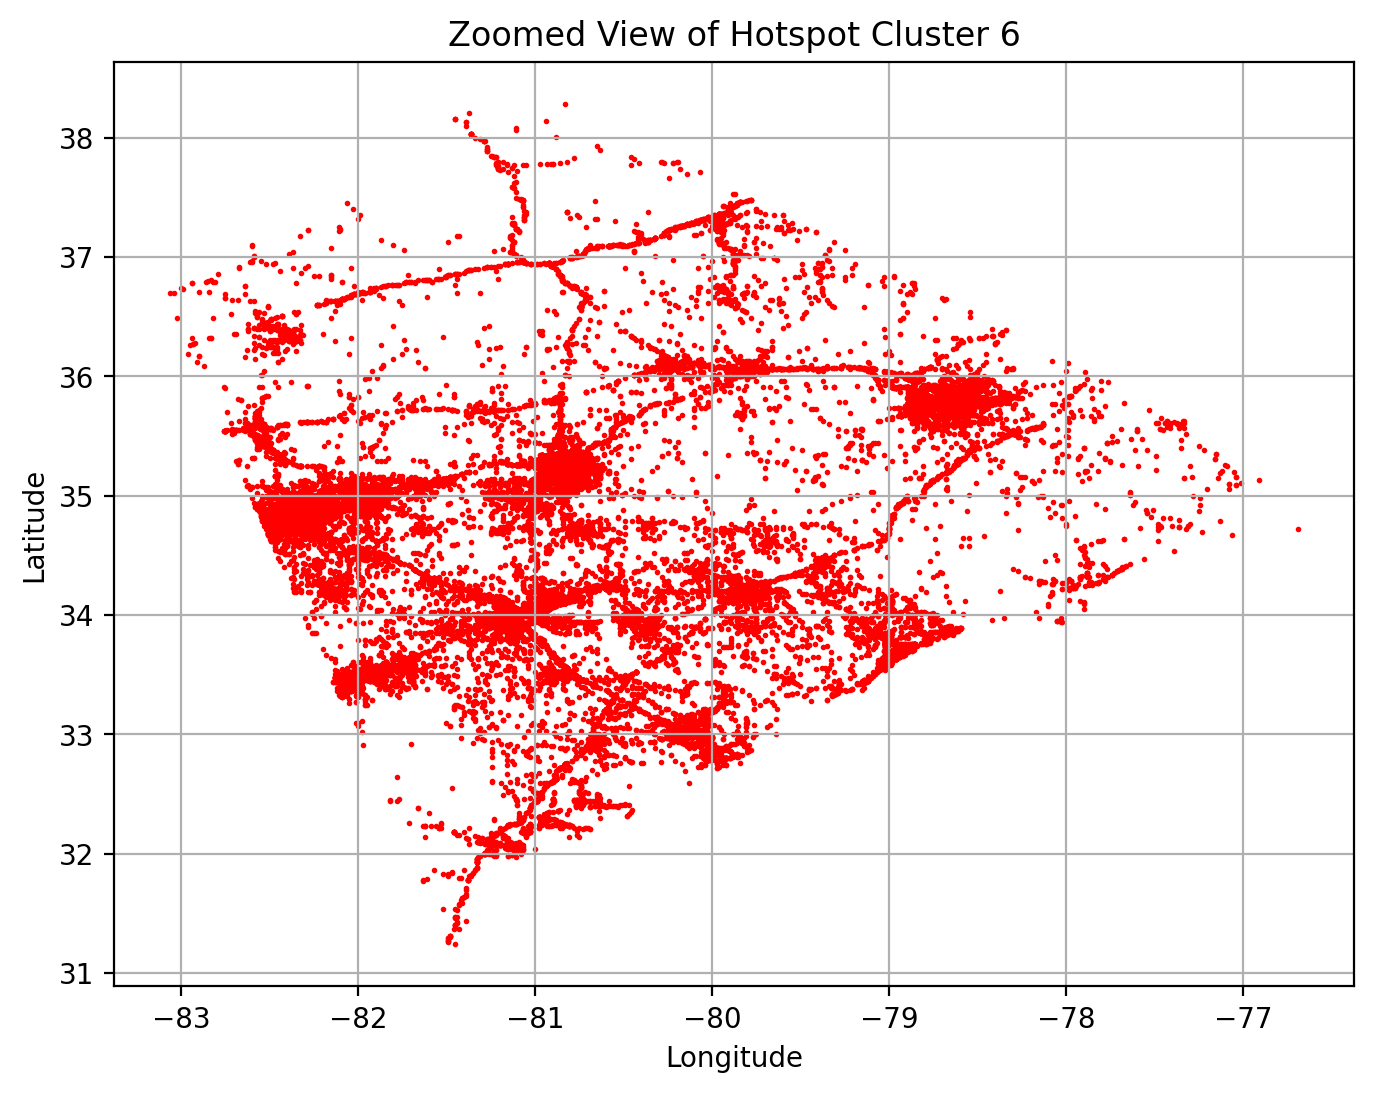

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Zoomed View of Hotspot Cluster 3')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

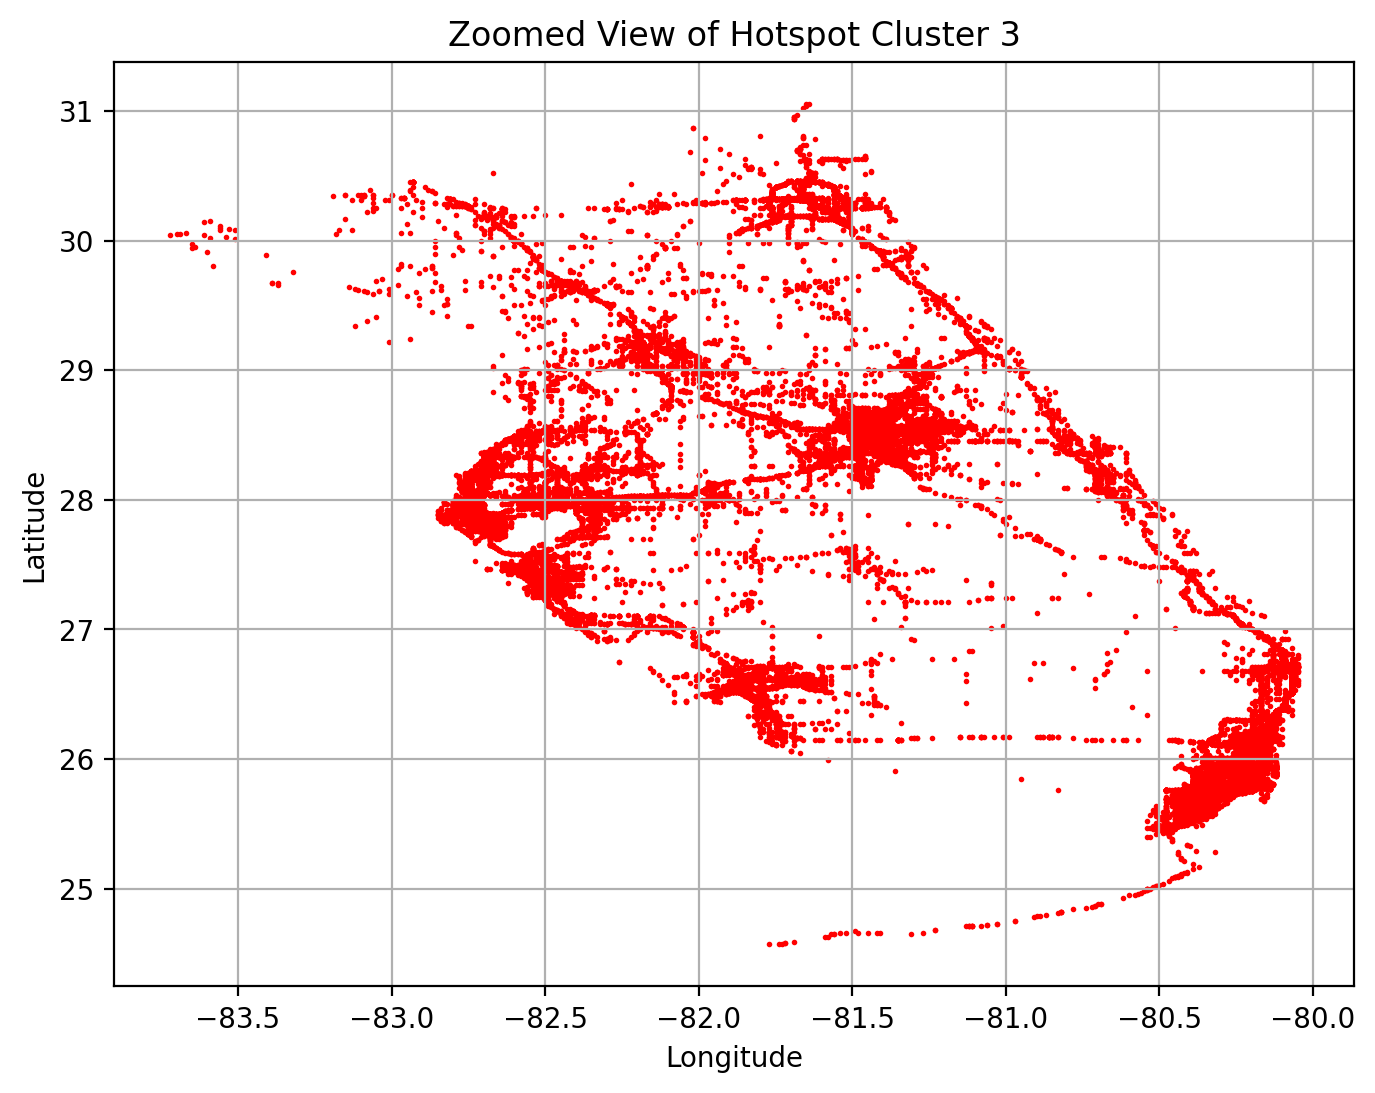

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Zoomed View of Hotspot Cluster 1')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

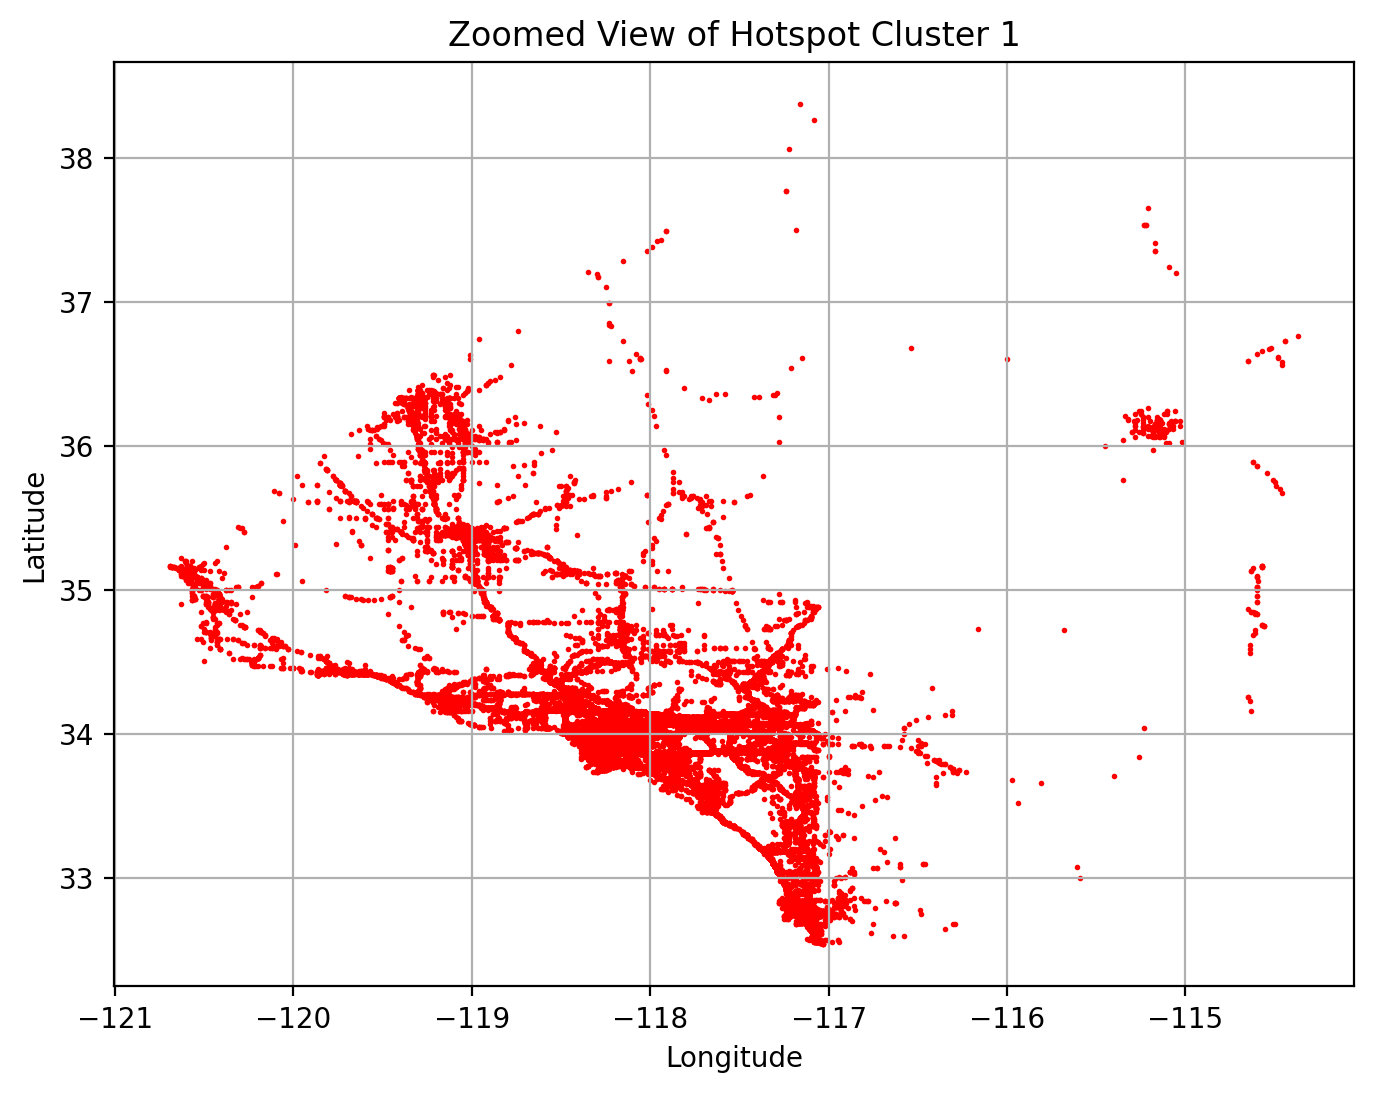

In [ ]:
top_clusters = unique[np.argsort(counts)[-3:]]  # Top 3 clusters

for cluster in top_clusters:
    plt.figure(figsize=(8,6))
    mask = (labels == cluster)
    plt.scatter(X_rounded[mask, 1], X_rounded[mask, 0], s=1, c='red')
    plt.title(f'Zoomed View of Hotspot Cluster {cluster}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()


<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Longitude', ylabel='Latitude'>

Text(0.5, 1.0, 'Accident Density Heatmap')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

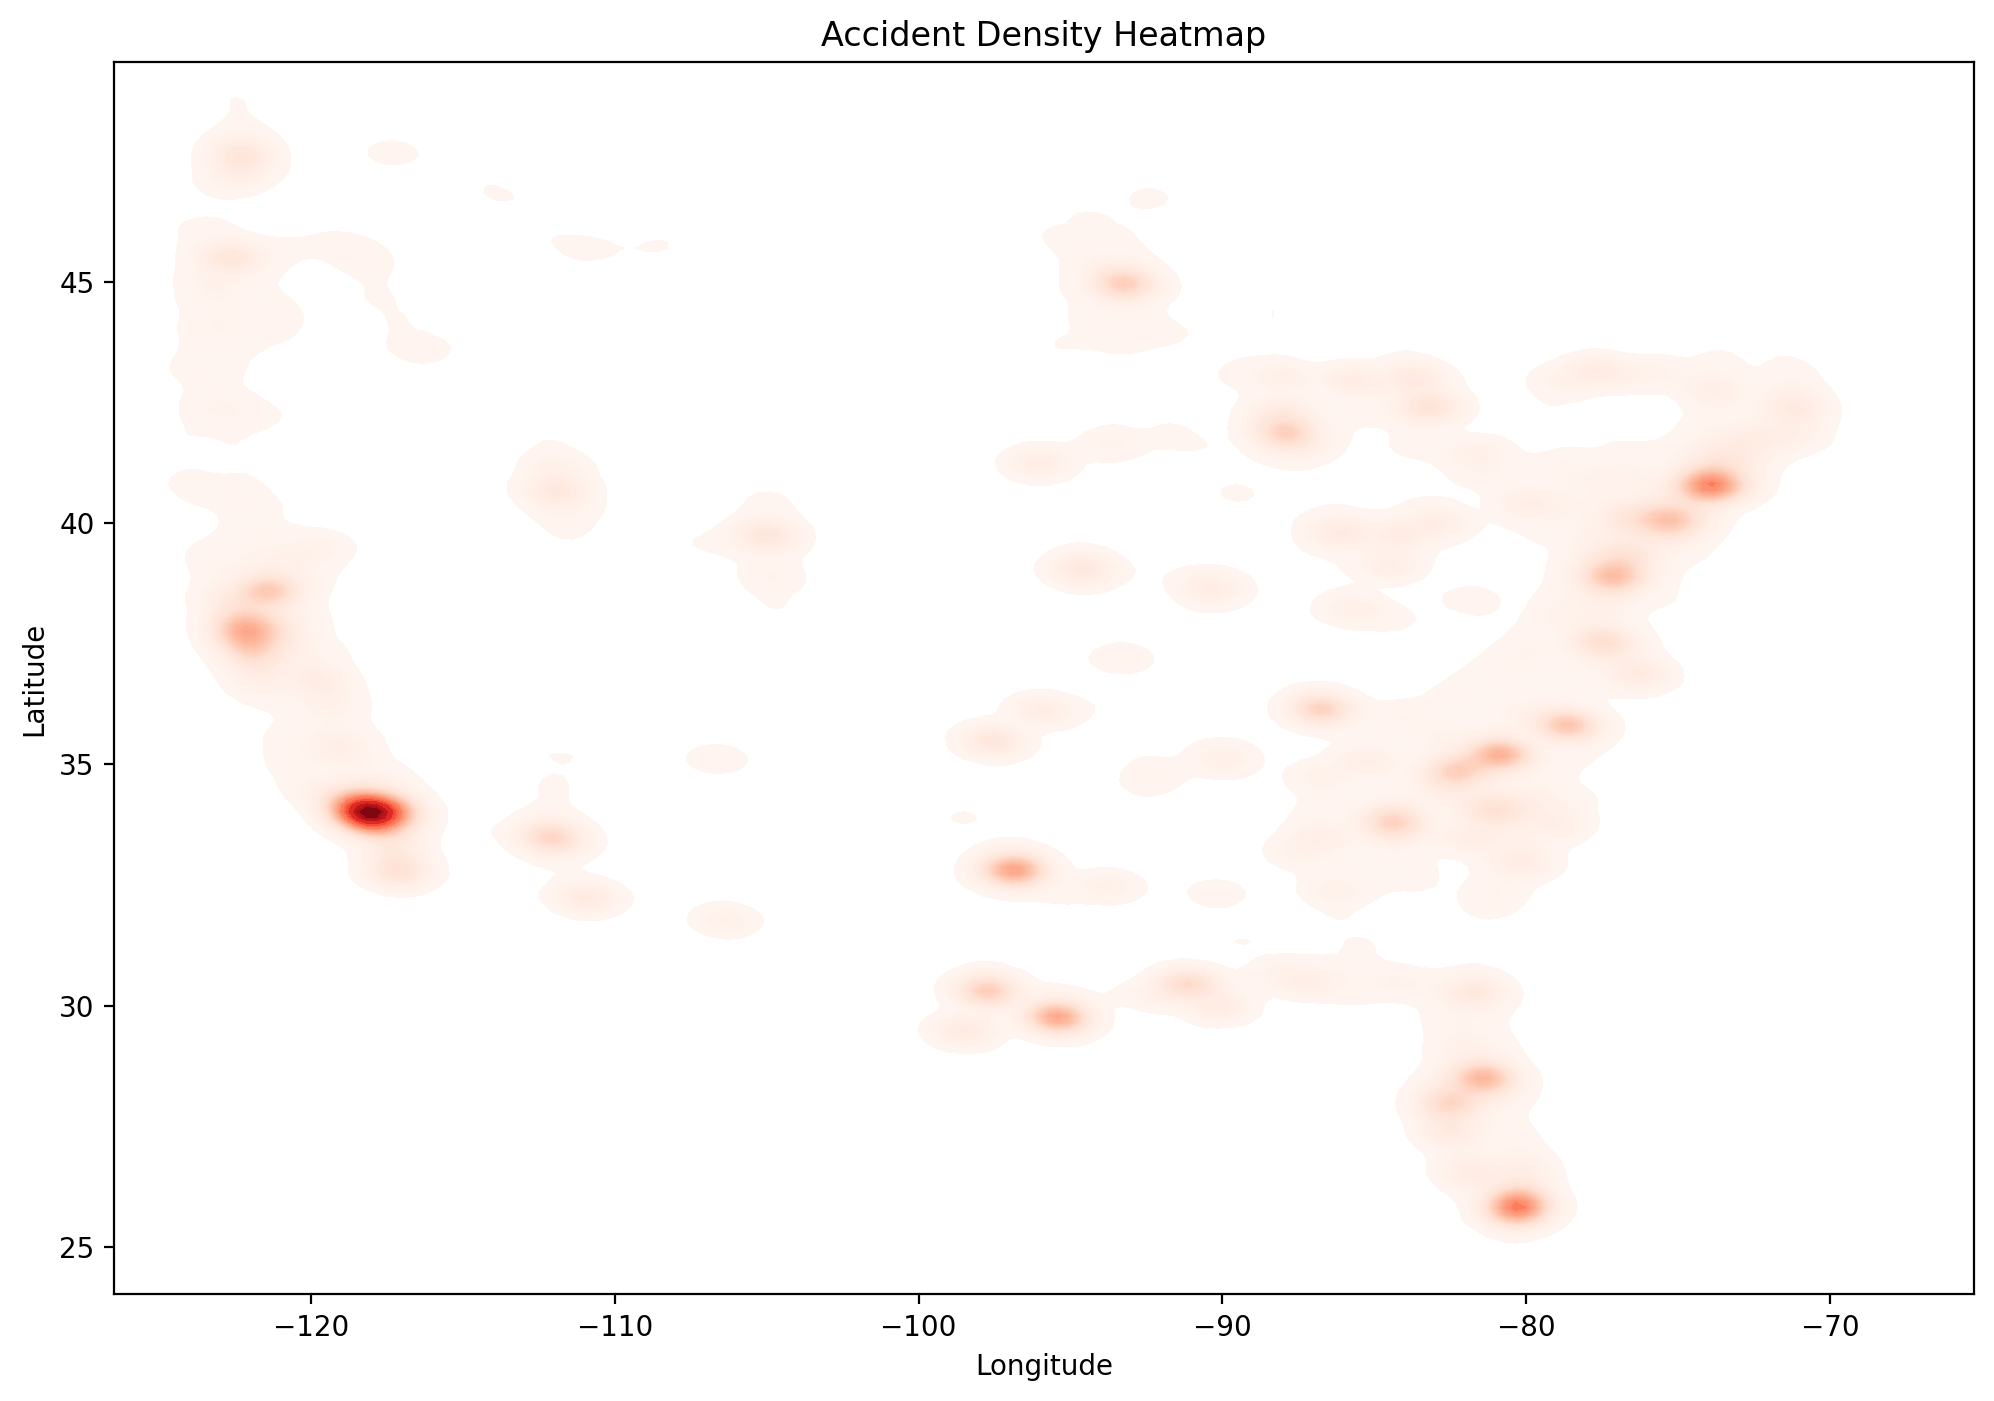

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.kdeplot(
    x=pdf['Longitude'],
    y=pdf['Latitude'],
    cmap="Reds",
    fill=True,         # not shade
    bw_adjust=0.5,
    levels=100,
    thresh=0.05
)
plt.title('Accident Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
